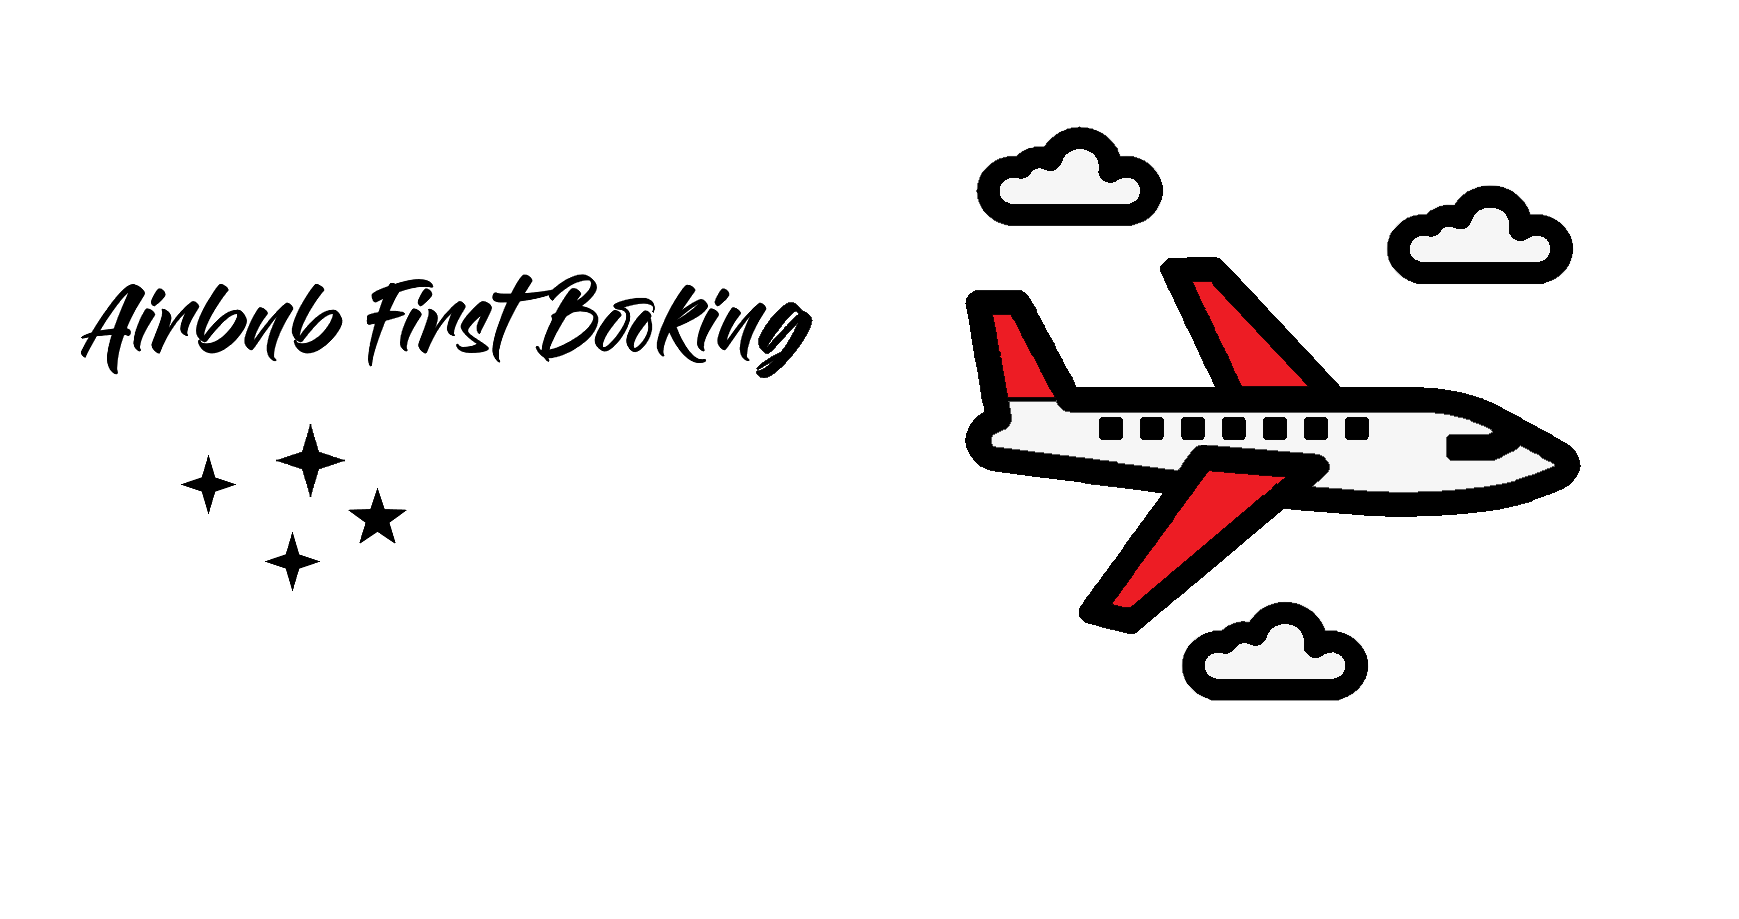

In [27]:
Image('../img/airbnb.png')

<p style='text-align:center'><i>Airbnb, Inc. is an American company that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities. Based in San Francisco, California, the platform is accessible via website and mobile app. Airbnb does not own any of the listed properties; instead, it profits by receiving commission from each booking.</i> ~Wiki</p>

**Bussiness Context**<br>
New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.
1. Predict the user destination based on user info and sessions actions.

**Marketplace**<br>
The marketplace is a bussiness model based on demand and offer, the new client install the app or acess the airbnb site for search your next booking, this new client demand a booking, the city or country is the offer for the new client to travel, the money basically comes from a tax based on demand and offer transaction.
- **Offer** People offering accommodation.
    - Number of New Users.
    - Channels where these new users come (Online & Offline)
    - LTV (Life Time Value)
    - CAC (Client Aquisition Cost)
    - Frequency of Bookings.
    - Bounce Rate (On App or Website)
    - Other Site/App Metrics.
- **Demand** People finding accomodations.
    - Number of Country to Booking.
    - Mean price of theses countries.
    - Properties Size / Diversity.
    - Country Marketing.
    - Property Quality.
    
**First Assumptions**<br>
1. Have good photos of theses properties to user make a booking ?
2. How is the quality of theses properties to user make a booking ?
3. Old users can come back to make a new Booking ?
4. How is the user experience on App / Site to make your booking ?
5. How is the budget of marketing on theses countryes ?
6. How is the cost of new users based on old users ?
7. The fee of transaction is acessible to all new users based on counties ?

**Steps to To Improve at Cycle 2**
1. SMOTEENN with no Correlated Features.
2. Use Sessions Dataset ( Check Data Granularity )
3. Embedding Space Study ( UMAP, T-SNE, PCA and Tree-Based )
4. Classification on Embedding Feature Space.

## 0.1. Imports

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from random import choices, sample
from scipy import stats as ss
from IPython.display import Image
from sklearn.utils import resample

from xgboost import XGBClassifier
from pandas_profiling import ProfileReport
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score

%matplotlib inline

## 0.2. Aux Functions

In [160]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['font.size'] = 13
warnings.filterwarnings('ignore')

palette=sns.diverging_palette(359, 359, n=5, s=999, l=50, center='dark')

class Utils():
    def metrics( self, df, with_stats=False ):
        n_att = df.select_dtypes( include=['int64', 'float64'] )
        c_att = df.select_dtypes( include=['object'] )

        if with_stats:
            d1 = pd.DataFrame( n_att.apply( np.mean ) ).T
            d2 = pd.DataFrame( n_att.apply( np.median ) ).T
            d3 = pd.DataFrame( n_att.apply( np.std ) ).T
            c1 = pd.DataFrame( n_att.apply( min ) ).T
            c2 = pd.DataFrame( n_att.apply( max ) ).T
            c3 = pd.DataFrame( n_att.apply( lambda x: x.max() - x.min() ) ).T
            c4 = pd.DataFrame( n_att.apply( lambda x: x.skew() ) ).T
            c5 = pd.DataFrame( n_att.apply( lambda x: x.kurtosis() ) ).T

            m = pd.concat( [c1, c2, c3, d1, d2, d3, c4, c5] ).T.reset_index()
            m.columns = ['att', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

            #m = m.style.highlight_min(axis=1, color='#99c0ff')

            return m, n_att, c_att

        else:
            return n_att, c_att

    def cramer_v( self, x, y ):
        cm = pd.crosstab( x, y ).values

        chi2 = ss.chi2_contingency( cm )[0]
        n    = cm.sum()
        r, k = cm.shape

        chi2corr = max( 0, chi2 - (r-1)*(k-1)/(n-1) )
        kcorr = k - (k-1)**2 / (n-1)
        rcorr = r - (r-1)**2 / (n-1)

        return np.sqrt( (chi2corr/n) / min(kcorr-1, rcorr-1) )
    
    def get_importance( self, columns, x_train, model ):
        imp = {}
        for i in range( len( columns) ):
            imp[x_train.columns[i]] = model.feature_importances_[i]
            
        return imp
    
    def cross_validation( self, model_name, model, x_train, y_train, k=5, verbose=False ):
        kfold = StratifiedKFold( n_splits=k, shuffle=True, random_state=32 )

        i=5
        bal_acc_list = []
        kap_acc_list = []
        for train_ix, val_ix in kfold.split( x_train, y_train ):
            if verbose:
                print(f'{i} -> {k} Cross Validation Folds')

            # Get Fold
            x_train_fold = x_train.iloc[train_ix]
            y_train_fold = y_train.iloc[train_ix]

            x_val_fold = x_train.iloc[val_ix]
            y_val_fold = y_train.iloc[val_ix]

            # Model Train & Full Prediction
            model = model.fit( x_train_fold, y_train_fold )
            yhat = model.predict( x_val_fold )

            kap = cohen_kappa_score( y_val_fold, yhat )
            bal = balanced_accuracy_score( y_val_fold, yhat )
            kap_acc_list.append( kap )
            bal_acc_list.append( bal )

            i+=1

        df = pd.DataFrame( columns=['Model Name', 'Kappa Score', 'Balanced Acc'], index=[0] )
        df['Model Name'] = df['Model Name'].fillna(model_name)
        df['Kappa Score'] = str(np.round(np.mean(kap_acc_list), 4)) + ' +/- ' + str(np.round(np.std(kap_acc_list), 4))
        df['Balanced Acc'] = str(np.round(np.mean(bal_acc_list), 4)) + ' +/- ' + str(np.round(np.std(bal_acc_list), 4))

        return df, bal_acc_list, kap_acc_list
    
    def ml_error( self, model_name, ytrue, yhat ):
        normal_acc   = accuracy_score( ytrue, yhat )
        balanced_acc = balanced_accuracy_score( ytrue, yhat )
        kappa_score  = cohen_kappa_score( ytrue, yhat )

        plot_confusion_matrix( ytrue, yhat, figsize=(13, 13) );

        return pd.DataFrame( {'Model Name': model_name, 
                              'Accuracy': normal_acc, 
                              'Balanced Accuracy': balanced_acc, 
                              'Kappa Score': kappa_score}, index=[0] )

    def args( self, bins=np.arange(0, 2, 1), hstep='step', lwidth=2, c='r', label='Sales', normed=False):
        return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

    def args_b( self, color=(1, 1, 1, 0), edgecolor=['navy', 'red'], linewidth=3 ):
        return {'linewidth': linewidth, 'color': color, 'edgecolor': edgecolor }

    def plot_country( self, df_bal, df_unb ):
        balanced = df_bal.groupby('country_destination').size().to_dict()
        unbalanced = df_unb.groupby('country_destination').size().to_dict()

        fig, ax = plt.subplots( 1, 2, figsize=(10, 4))
        ax[0].bar( unbalanced.keys(), unbalanced.values(), **args_b(edgecolor='k'))
        ax[1].bar( balanced.keys(), balanced.values(), **args_b(edgecolor='r'))
        for i, t in zip(range(2), ['Unbalanced', 'Balanced']):
            ax[i].set_title(t)

        return None
    
    def plot_response_var():
        fig, ax = plt.subplots( 1, 3, figsize=(20, 7))
        for i, d, c, l in zip( range(3), [df51, df_sen, df_stk], ['k', 'r', 'b'], ['Unbalanced', 'SMOTEEN', 'SMOTETomek'] ):
            ax[i].bar( d.country_destination.unique(), d.country_destination.value_counts(), **mp.args_b(edgecolor=c, linewidth=4) )
            ax[i].set_xlabel('Destinations')
            ax[i].set_ylabel('Counts')
            ax[i].set_title(l)

        return None

    def plot_percent( self, df, y_variable, percent, title ):
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.bar( df.country_destination, df[y_variable], **args_b() )
        ax.axhline( percent, linestyle='--', c='k', label='20%')
        ax.set_title(title);

        return None

    def plot_util_booking( self, df, y_variable, median=True ):
        if median:
            aux = df[[y_variable, 'country_destination']].groupby('country_destination').median().reset_index()
        else:
            aux = df[[y_variable, 'country_destination']].groupby('country_destination').mean().reset_index()
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        ax[0].scatter( aux.country_destination, aux[y_variable], **args_b() )
        ax[1].bar(aux.loc[aux.country_destination != 'NDF', 'country_destination'], aux.loc[aux.country_destination != 'NDF', y_variable], **args_b())
        ax[0].set_title('With Outlier');
        ax[1].set_title('Without Outlier');

        return None
    
mp = Utils()

## 0.3. Load Datasets

In [357]:
df_raw = pd.read_csv('../data/train_users_2.csv')
df_ses = pd.read_csv('../data/sessions.csv')

# 1.0. Descriptive Statistical

In [358]:
df1 = df_raw.copy()

## 1.1. Rename Columns

Dataset have *snake_case* for columns names.

## 1.2. Dataset Dimension

In [6]:
print(f'Number of Columns for Train Dataset: {df1.shape[1]}')
print(f'Number of Rows for Train Dataset: {df1.shape[0]}\n')

print(f'Number of Columns for Sessions Dataset: {df_ses.shape[1]}')
print(f'Number of Rows for Sessions Dataset: {df_ses.shape[0]}')

Number of Columns for Train Dataset: 16
Number of Rows for Train Dataset: 213451

Number of Columns for Sessions Dataset: 6
Number of Rows for Sessions Dataset: 10567737


## 1.3. Data Types

In [7]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [8]:
df_ses.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.4. Check Na

In [9]:
df1.isna().sum() / len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [10]:
df_ses.isna().sum() / len(df_ses)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.5. Fillout Na

### 1.5.1. Fillout Na (Train Dataset) 

In First Cycle:<br>
**age**: Fillna Mean between a normal (Filtred people with less 120 years old).<br>
**data_first_booking**: Have *N* datetime when users dont maked a Booking.<br>
**first_affiliate_tracked**: Is a Categorical Dataset, hard to fillna without Bias.<br>

In [13]:
#date_first_booking
df1['date_first_booking'] = df1['date_first_booking'].fillna( df1.loc[~df1['date_first_booking'].isna(), 'date_first_booking'].max() )

#age
std_age = int(df1.loc[(df1['age'] < 120) & (df1['age'] > 15), 'age'].std())
mean_age = int(df1.loc[(df1['age'] < 120) & (df1['age'] > 15), 'age'].mean())
fillna_ages = [np.random.randint(std_age, mean_age) for _ in range( 0, 87990 )]
df1.loc[df1['age'].isna(), 'age'] = fillna_ages

df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

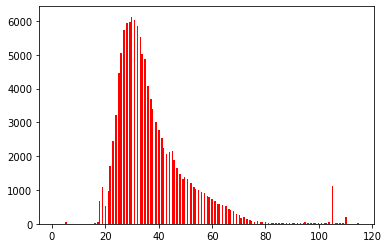

In [14]:
plt.hist(df1.loc[df1['age'] < 120, 'age'], bins=200, color='r');

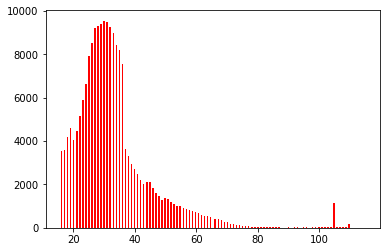

In [14]:
plt.hist(df1.loc[df1['age'] < 120, 'age'], bins=200, color='r');

### 1.5.2. Fillout Na (Sessions Dataset) 

First Cycle just Drop Na because have 10567737 rows on Session Dataset.

In [15]:
df_ses = df_ses.dropna()

## 1.6. Change Data Types

In [16]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [17]:
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'], format='%Y-%m-%d')

df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

df1['age'] = df1['age'].astype('int64')

## 1.7. Check Balanced Dataset

In [12]:
(df1.country_destination.value_counts() / len(df1)).apply( lambda x: str(np.round(x*100, 3))+' %' )

NDF      56.939 %
US       30.198 %
other      4.92 %
FR        2.405 %
IT        1.371 %
GB        1.135 %
ES        1.092 %
CA        0.686 %
DE        0.517 %
NL         0.37 %
AU        0.261 %
PT        0.107 %
Name: country_destination, dtype: object

## 1.8. Descriptive Statistical

### 1.7.1. Numerical Attributes

#### 1.7.1.1. Train Dataset Descriptive Statistical

In [21]:
m, _, _ = mp.metrics( df1, with_stats=True )
m

,att,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,33.142236,31.0,12.873121,2.208657,8.093446
1,signup_flow,0.0,25.0,25.0,3.106325,0.0,7.485174,2.313187,3.699503


#### 1.7.1.2. Sessions Dataset Descriptive Statistical

0.000 Secs on Page? 

In [25]:
m, _, _, = mp.metrics( df_ses, with_stats=True )
m

,att,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.2. Categorical Attributes

In [27]:
_, c_att = mp.metrics(df1)
c_att = c_att.drop('id', axis=1)

c_att.describe().T

,count,unique,top,freq
gender,196096,4,-unknown-,82339
signup_method,196096,3,basic,137465
language,196096,25,en,189445
affiliate_channel,196096,8,direct,126873
affiliate_provider,196096,17,direct,126648
first_affiliate_tracked,196096,7,untracked,103271
signup_app,196096,4,Web,168950
first_device_type,196096,9,Mac Desktop,85380
first_browser,196096,49,Chrome,60987
country_destination,196096,12,NDF,111655


In [28]:
_, c_att = mp.metrics(df_ses)
c_att = c_att.drop('user_id', axis=1)

c_att.describe().T

,count,unique,top,freq
action,9213930,347,show,2178382
action_type,9213930,10,view,3545621
action_detail,9213930,155,view_search_results,1770931
device_type,9213930,14,Mac Desktop,3019523


In [18]:
df1.to_csv('../data_backup/df1.csv')

# 2.0. Feature Engineering

In [20]:
df2 = pd.read_csv('../data_backup/df1.csv')
df2 = df2.drop('Unnamed: 0', axis=1)

df2.date_first_booking     = pd.to_datetime( df2.date_first_booking, format='%Y-%m-%d %H:%M:%S' )
df2.timestamp_first_active = pd.to_datetime( df2.timestamp_first_active, format='%Y-%m-%d %H:%M:%S' )
df2.date_account_created   = pd.to_datetime( df2.date_account_created, format='%Y-%m-%d %H:%M:%S' )

## 2.1. Mind Map

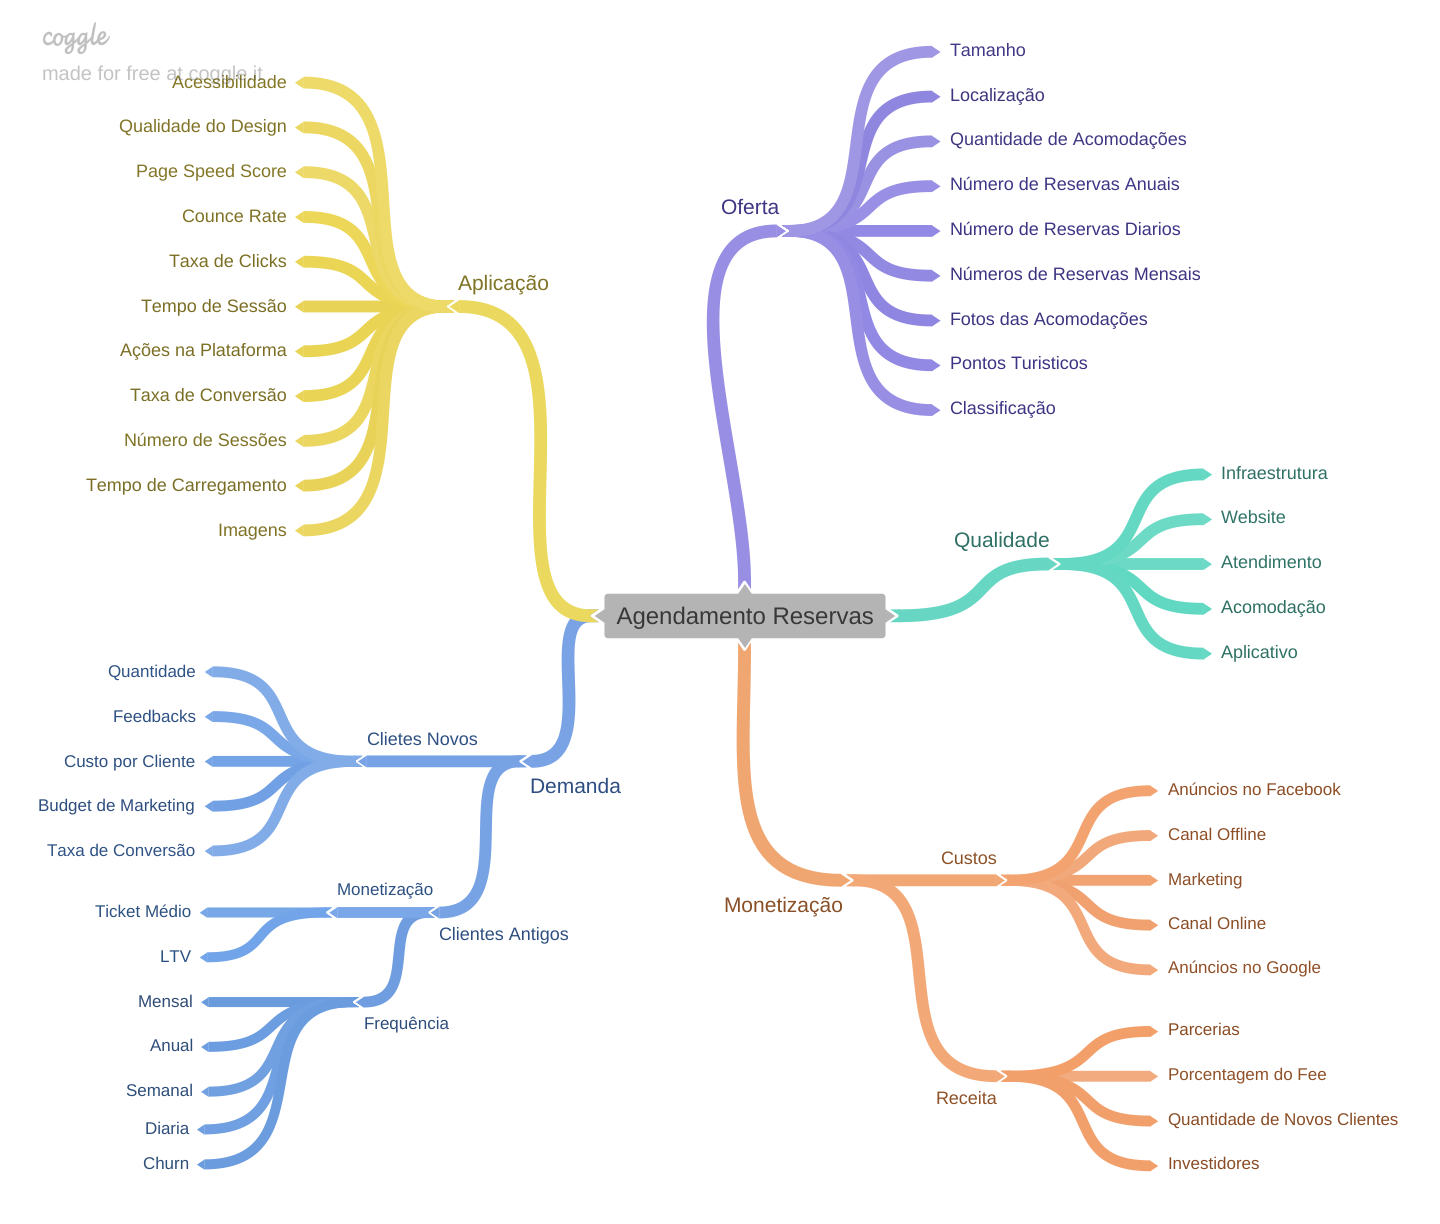

In [26]:
Image('../img/mind.png')

## 2.2. Hypothesis List

**1.** Em todos os destinos, os usuários levam em média 15 dias para fazer a primeira reserva no Airbnb desde a primeira ativação.

**2.** Em todos os destinos, os usuários levam 3 dias em média para fazer o cadastro no site.

**3.** O volume de reservas anual feitas durante o verão aumentaram 20% para os destinos dentro dos EUA.

**4.** Usuários do sexo feminino fazer 10% mais reservas para paises fora dos EUA.

**5.** O canal de Marketing Google representa 40% de reservas para paises fora dos EUA.

**6.** O Destino USA representamais de 20% em todos os canais.

**7.** A idade média das pessoas é de 35 anos em todos os destinos.

**8.** A porcentagem de usuários que usam o site na lingua inglês-americano para reservar acomodações em qualquer destino é maior que 90%

**9.** O Número de reservas do Airbnb é percentualmente crescente ao longo dos anos.

**10.** 75% das pessoas que deram feedbacks positivos retornaram para mais uma reserva.

## 2.3. Feature Engineering

**days_from_first_active_util_booking**: Diff between first booking to first active on App / Airbnb Site. <br>
**days_from_account_crated_util_booking**: Diff between first booking to Account Created. <br>
**days_from_first_active_util_account_crated**: Diff between account created to first active on App / Airbnb Site. 

Future check:
1. First Browser.

In [21]:
df2['days_from_first_active_util_booking']        = (df2.date_first_booking - pd.to_datetime(df2.timestamp_first_active.dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')).dt.days
df2['days_from_account_crated_util_booking']      = (df2.date_first_booking - df2.date_account_created).dt.days
df2['days_from_first_active_util_account_crated'] = (df2.date_account_created - pd.to_datetime(df2.timestamp_first_active.dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')).dt.days

In [22]:
# timestamp_first_active Data Derivation
df2['day_first_active']   = df2.timestamp_first_active.dt.day
df2['week_first_active']  = df2.timestamp_first_active.dt.week
df2['month_first_active'] = df2.timestamp_first_active.dt.month
df2['year_first_active']  = df2.timestamp_first_active.dt.year
df2['week_of_year_first_active'] = df2.timestamp_first_active.dt.weekofyear

# date_account_created Data Derivation
df2['day_account_created']   = df2.date_account_created.dt.day
df2['week_account_created']  = df2.date_account_created.dt.week
df2['month_account_created'] = df2.date_account_created.dt.month
df2['year_account_created']  = df2.date_account_created.dt.year
df2['week_of_year_account_created'] = df2.date_account_created.dt.weekofyear

# date_first_booking Data Derivation
df2['day_first_booking']   = df2.date_first_booking.dt.day
df2['week_first_booking']  = df2.date_first_booking.dt.week
df2['month_first_booking'] = df2.date_first_booking.dt.month
df2['year_first_booking']  = df2.date_first_booking.dt.year
df2['week_of_year_first_booking'] = df2.date_first_booking.dt.weekofyear

In [9]:
df2.shape

(196096, 34)

In [10]:
df_ses.shape

(9213930, 6)

# 3.0. Data Filtering

In [23]:
df3 = df2.copy()

## 3.1. Filtering Rows 

In [24]:
df_ses = df_ses[df_ses.secs_elapsed > 1]
df_ses = df_ses[df_ses.secs_elapsed < 150000.0]

In [25]:
df_ses.shape

(8882938, 6)

In [26]:
df_ses.describe().T

,count,mean,std,min,25%,50%,75%,max
secs_elapsed,8882938.0,9809.214404,20512.500101,2.0,343.0,1324.0,8669.0,149999.0


## 3.2. Filtering Columns 

In [27]:
# First Cycle Simple Droping the Derived features
df3 = df3.drop( columns=['timestamp_first_active', 'date_first_booking', 'date_account_created'], axis=1 )

# | Second Cycle | New Dataframe without Correlated Features.
# 1. Full Cleaned Dataset
# 2. Better SMOTEENN Perfromace for Over and Undersampling ( Reduced Dimensions )

df_ses = df_ses.drop( columns=['action', 'action_detail'], axis=1 ) # > .95 Corr features.

df31 = df3.drop( columns=['days_from_first_active_util_booking',  'year_first_active',  'month_first_active', 'day_first_active',
                          'week_of_year_first_active', 'month_first_booking', 'month_account_created', 'week_of_year_account_created',
                          'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider', 'week_account_created',
                          'first_browser', 'first_device_type', 'signup_app', 'language'], axis=1 )

In [28]:
df3.to_csv('../data_backup/df3.csv')
df31.to_csv('../data_backup/df3_c2.csv')

# 4.0. Dataset Balance

With all Dataset

In [5]:
df3 = pd.read_csv('../data_backup/df3.csv')
df3 = df3.drop(columns=['Unnamed: 0'], axis=1)

df3 = df3.drop(columns=['language', 'id'], axis=1)
n_att, c_att = mp.metrics( df3 )

In [166]:
# Frequency Encoding
for k in c_att.columns.tolist():
    c_att[k] = c_att[k].map((c_att.groupby(k).size() / len(df3)).to_dict())

df31 = pd.concat( [n_att, c_att], axis=1 )
df31 = df31.iloc[:, :-1]

In [169]:
df3.country_destination.value_counts()

NDF      111642
US        59236
other      9654
FR         4712
IT         2693
GB         2223
ES         2145
CA         1356
DE         1008
NL          726
AU          515
PT          208
Name: country_destination, dtype: int64

Reduced NDF Rows

**Second Cycle using df31 ( Features Corr Drop )**

In [43]:
df32 = df31[(df31.country_destination == 'NDF')].reset_index( drop=True )
df32 = df32.iloc[:60000, :]

df33 = df31[df31.country_destination != 'NDF']
df34 = pd.concat( [df33, df32], axis=0 ).reset_index( drop=True )

n_att, c_att = mp.metrics( df34 )

# Frequency Encoding
for k in c_att.columns.tolist():
    c_att[k] = c_att[k].map((c_att.groupby(k).size() / len(df3)).to_dict())

df36 = pd.concat( [n_att, c_att], axis=1 )
df36 = df36.iloc[:, :-1]

In [44]:
df31.country_destination.value_counts()

NDF      111655
US        59217
other      9648
FR         4716
IT         2688
GB         2226
ES         2141
CA         1346
DE         1013
NL          726
AU          511
PT          209
Name: country_destination, dtype: int64

In [45]:
df34.country_destination.value_counts()

NDF      60000
US       59217
other     9648
FR        4716
IT        2688
GB        2226
ES        2141
CA        1346
DE        1013
NL         726
AU         511
PT         209
Name: country_destination, dtype: int64

In [50]:
df36 = df36.drop('id', axis=1)

In [52]:
df36.head(2).T

,0,1
age,56.000000,42.000000
signup_flow,3.000000,0.000000
days_from_account_crated_util_booking,-57.000000,278.000000
days_from_first_active_util_account_crated,476.000000,765.000000
week_first_active,24.000000,44.000000
day_account_created,28.000000,5.000000
year_account_created,2010.000000,2011.000000
day_first_booking,2.000000,8.000000
week_first_booking,31.000000,36.000000
gender,0.253162,0.253162


## 4.1. SMOTEEN & SMOTETomeklinks

In [4]:
ratio_sn = \
{'NDF': 60000,
 'US':  70000,
 'other': 9654*5,
 'FR': 4712*10,
 'IT': 2693*15,
 'GB': 2223*20,
 'ES': 2145*20,
 'CA': 1356*27,
 'DE': 1008*32,
 'NL': 726*50,
 'AU': 515*80,
 'PT': 208*150}

ratio_sn

{'NDF': 60000,
 'US': 70000,
 'other': 48270,
 'FR': 47120,
 'IT': 40395,
 'GB': 44460,
 'ES': 42900,
 'CA': 36612,
 'DE': 32256,
 'NL': 36300,
 'AU': 41200,
 'PT': 31200}

### 4.1.1. SMOTEEN

In [99]:
sn = SMOTEENN(sampling_strategy=ratio_sn, n_jobs=-1)
x_sn, y_sn = sn.fit_resample(df36, df34.country_destination)

In [104]:
df34.country_destination.value_counts()

NDF      60000
US       59217
other     9648
FR        4716
IT        2688
GB        2226
ES        2141
CA        1346
DE        1013
NL         726
AU         511
PT         209
Name: country_destination, dtype: int64

In [100]:
y_sn.value_counts()

NDF      59993
AU       39438
GB       35401
ES       33932
FR       33645
NL       32979
PT       30541
CA       30332
IT       30098
other    27950
DE       27376
US       16341
Name: country_destination, dtype: int64

In [103]:
df_senn = pd.concat( [x_sn, y_sn], axis=1 )

In [107]:
df_senn.to_csv('../data_backup/df_senn.csv')

### 4.1.2. SMOTETomeklinks

In [106]:
ratio = \
{'NDF': 60000,
 'US':  59217,
 'other': 9654*5,
 'FR': 4712*10,
 'IT': 2693*15,
 'GB': 2223*20,
 'ES': 2145*20,
 'CA': 1356*27,
 'DE': 1008*32,
 'NL': 726*50,
 'AU': 515*80,
 'PT': 208*150}

ratio

{'NDF': 60000,
 'US': 59217,
 'other': 48270,
 'FR': 47120,
 'IT': 40395,
 'GB': 44460,
 'ES': 42900,
 'CA': 36612,
 'DE': 32256,
 'NL': 36300,
 'AU': 41200,
 'PT': 31200}

In [109]:
tk = SMOTETomek(sampling_strategy=ratio, n_jobs=-1, random_state=32)
x_tk, y_tk = tk.fit_resample(df36, df34.country_destination)

In [8]:
df3.country_destination.value_counts()

NDF      111642
US        59236
other      9654
FR         4712
IT         2693
GB         2223
ES         2145
CA         1356
DE         1008
NL          726
AU          515
PT          208
Name: country_destination, dtype: int64

In [110]:
y_tk.value_counts()

NDF      59998
US       55363
other    46161
FR       45903
GB       43844
ES       42247
AU       41125
IT       39550
CA       36210
NL       36149
DE       31939
PT       31165
Name: country_destination, dtype: int64

In [111]:
df_stomek = pd.concat( [x_tk, y_tk], axis=1 )

In [112]:
df_stomek.to_csv('../data_backup/df_stomek.csv')

# 5.0. Exploratory Data Analysis

In [6]:
df_sen = pd.read_csv('../data_backup/df_senn.csv')
df_stk = pd.read_csv('../data_backup/df_stomek.csv')
df_sen = df_sen.drop('Unnamed: 0', axis=1)
df_stk = df_stk.drop('Unnamed: 0', axis=1)

df51 = pd.read_csv('../data_backup/df3_c2.csv')
df52 = pd.read_csv('../data_backup/df3.csv')
df51 = df51.drop('Unnamed: 0', axis=1)
df52 = df52.drop('Unnamed: 0', axis=1)

## 5.1. Univariable Analysis - Feature Behavior (Balanced Dataset)

In [56]:
n_att_un, c_att_un = mp.metrics( df51 )
n_att_se, c_att_se = mp.metrics( df_sen )
n_att_st, c_att_st = mp.metrics( df_stk )

#n_att_ss, c_att_ss = mp.metrics( df_ses )

### 5.1.1. Responde Variable 

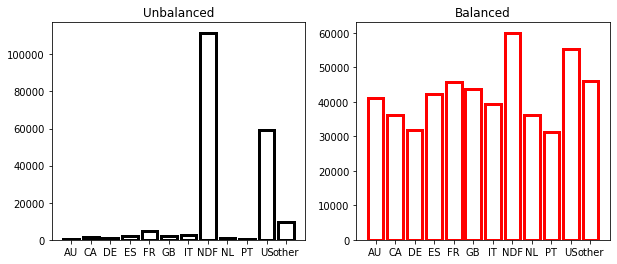

In [57]:
mp.plot_country(df51, df52)

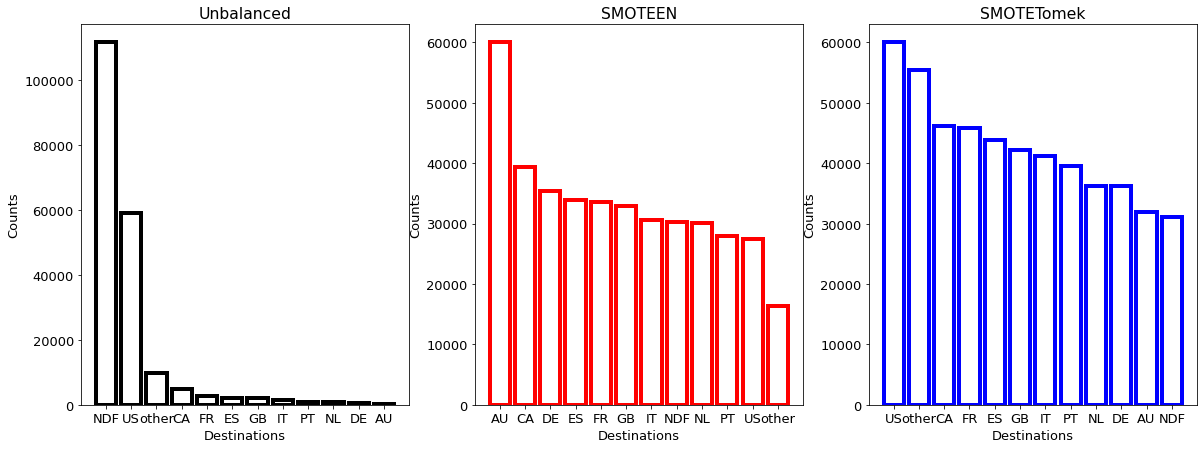

In [53]:
mp.plot_response_var()

### 5.1.2. Numerical Variables 

In [59]:
plt.rcParams['figure.figsize'] = [25, 18]
plt.tight_layout(w_pad=2., h_pad=5.)

<Figure size 1800x1296 with 0 Axes>

#### 5.1.2.1. Numerical Variables (Train Dataset)

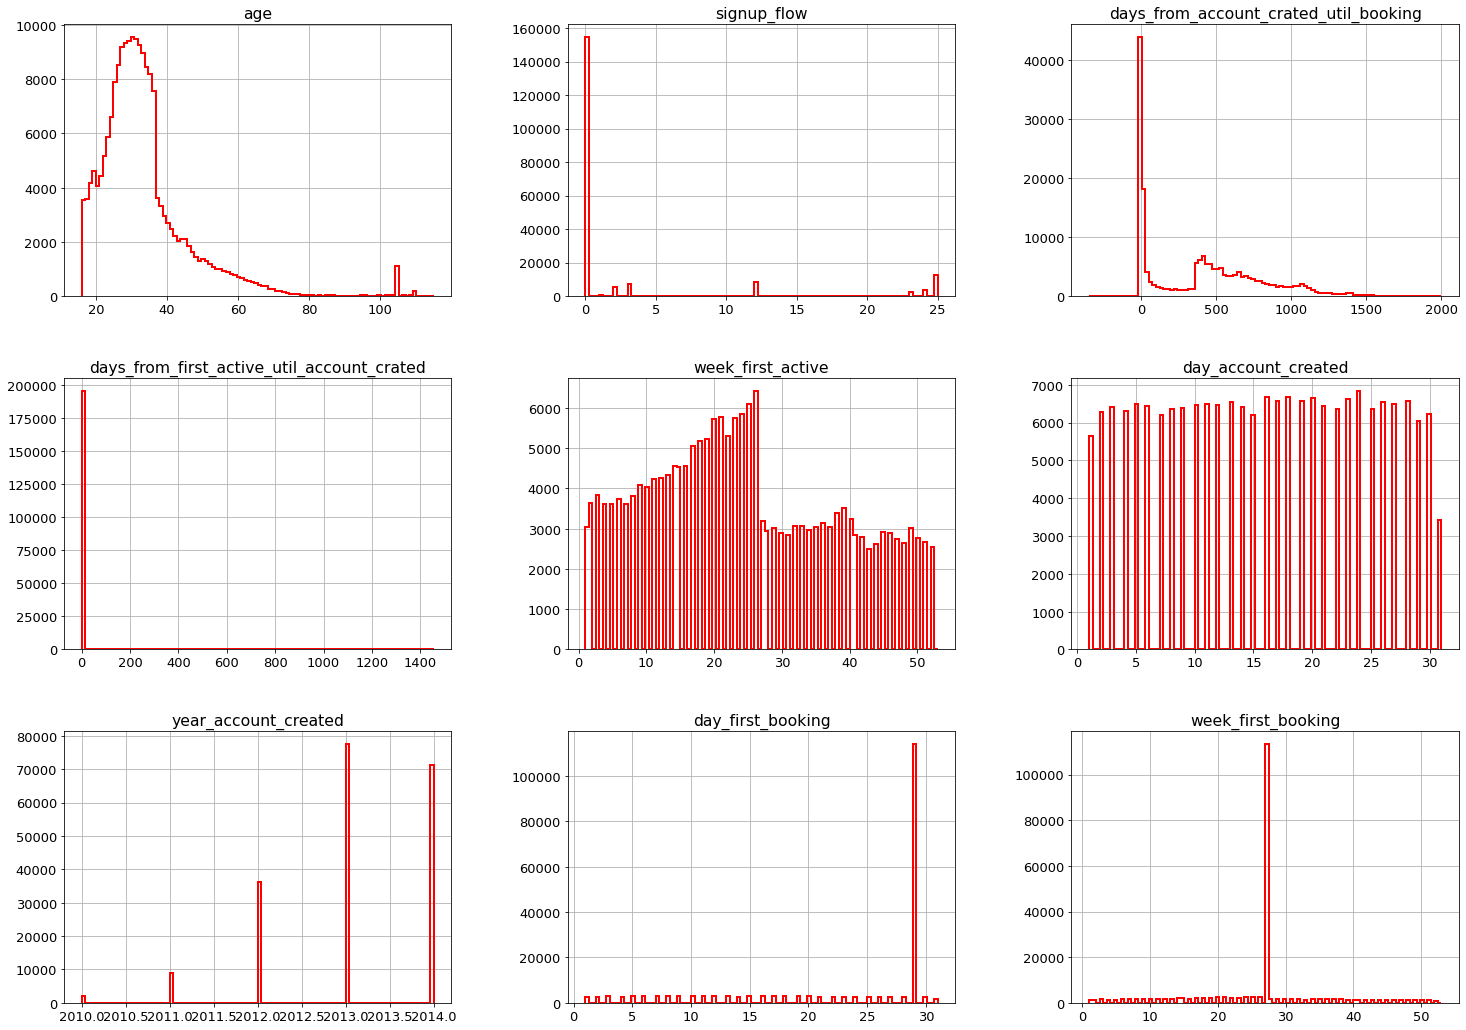

In [60]:
# Unbalanced Dataset
n_att_un.hist(**mp.args(bins=100));

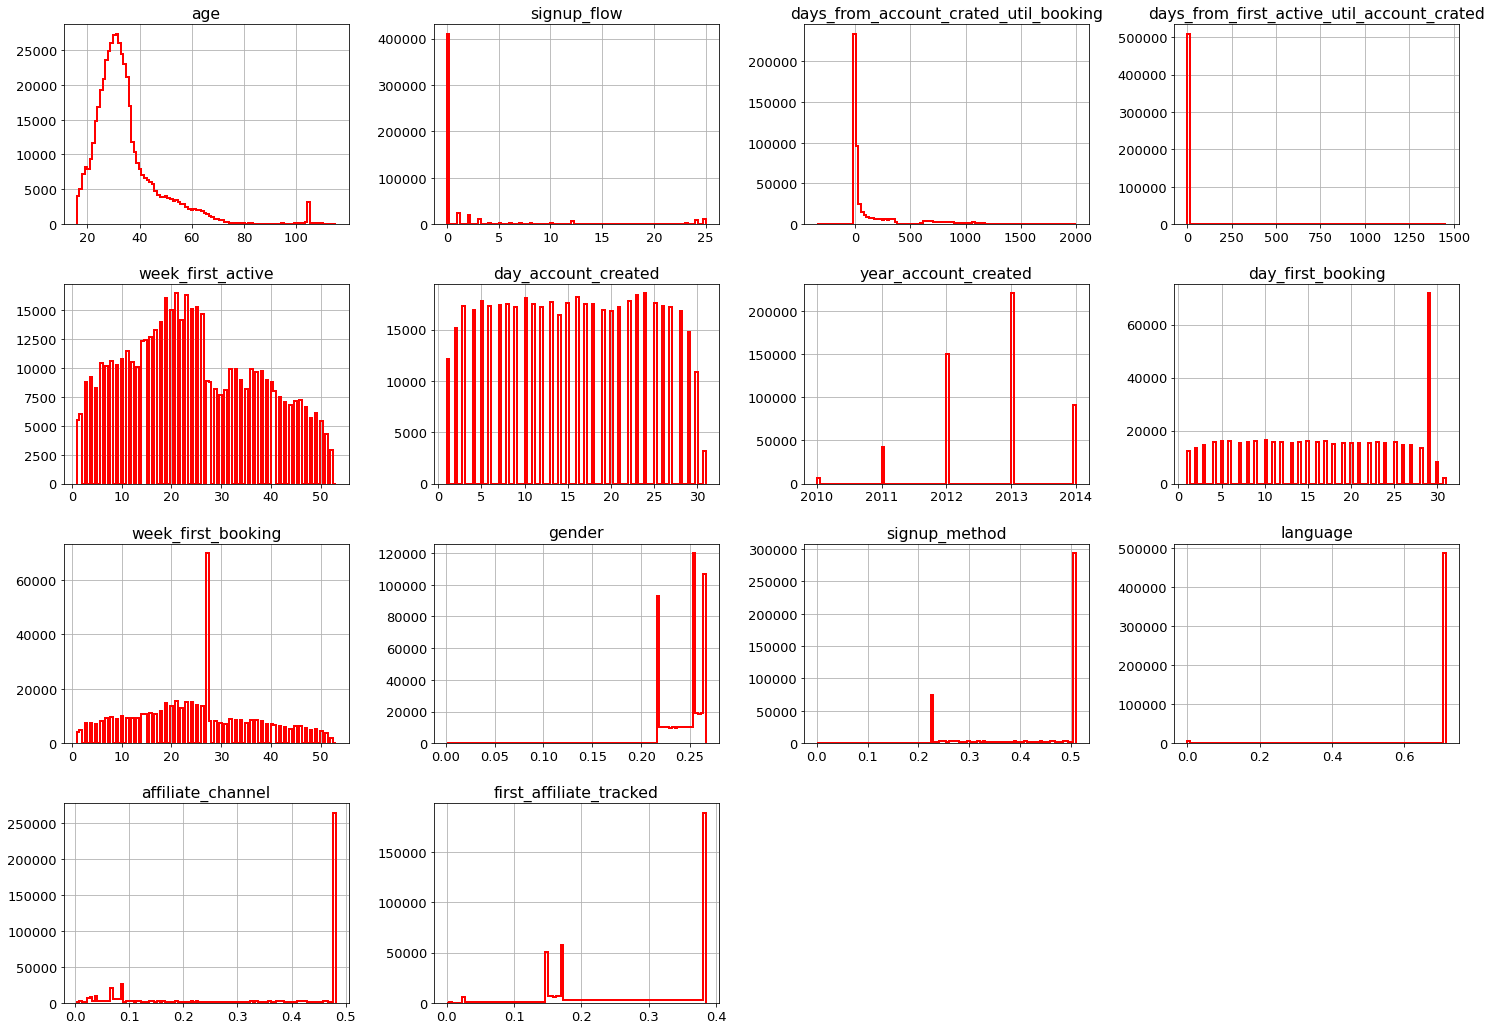

In [62]:
# Balanced Dataset
n_att_st.hist(**mp.args(bins=100));

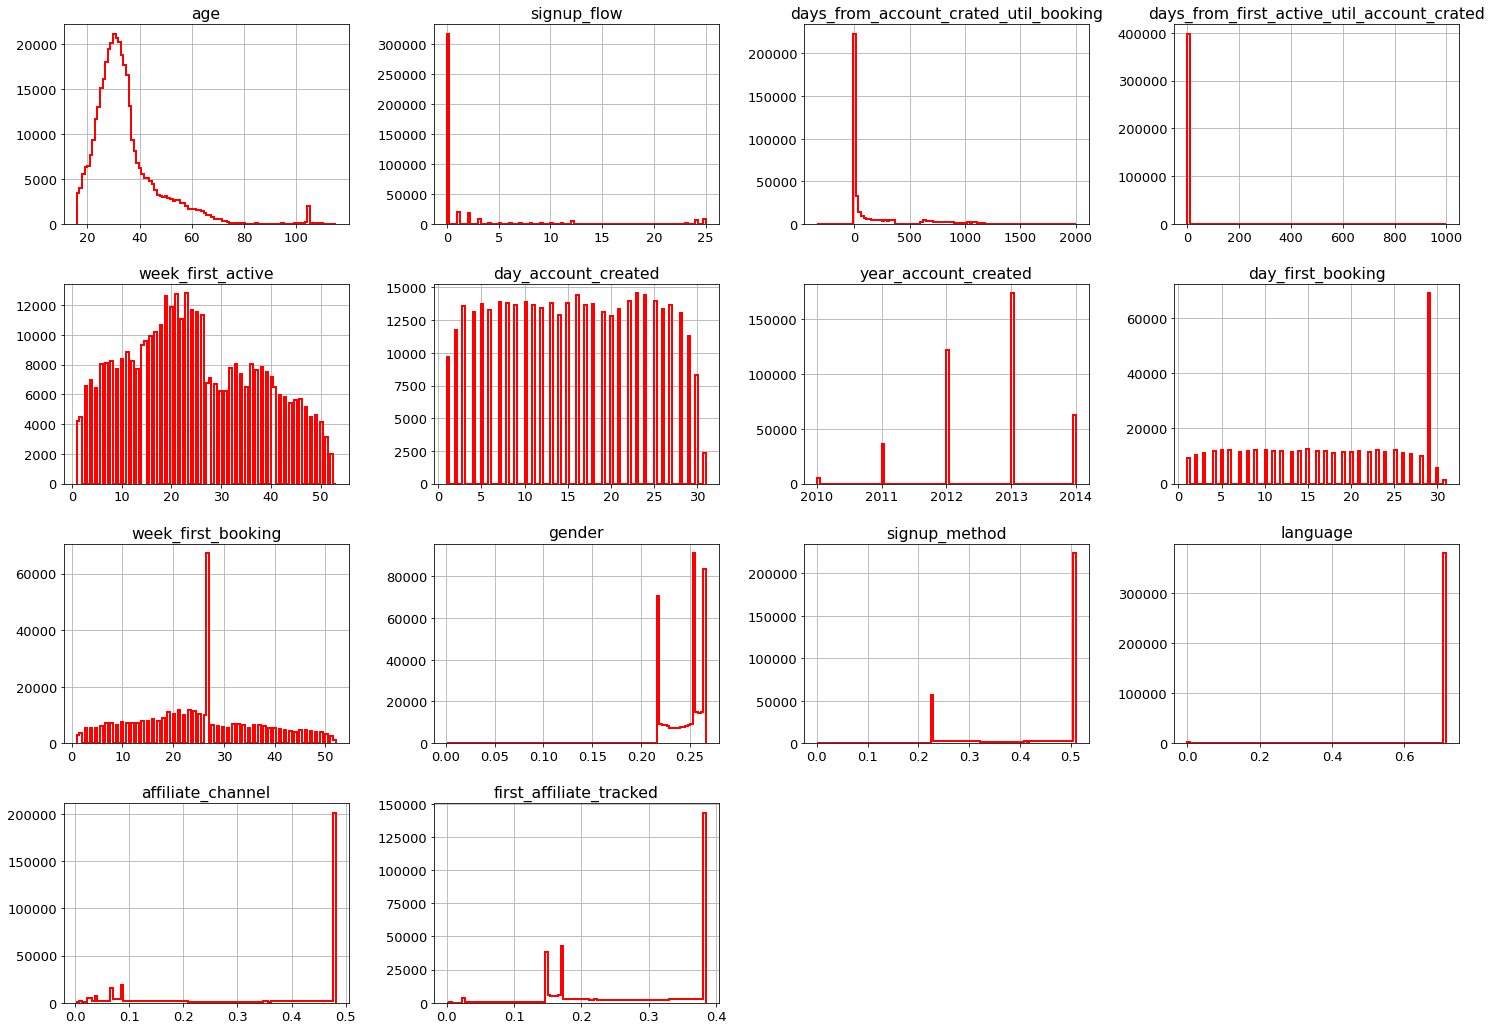

In [63]:
n_att_se.hist(**mp.args(bins=100));

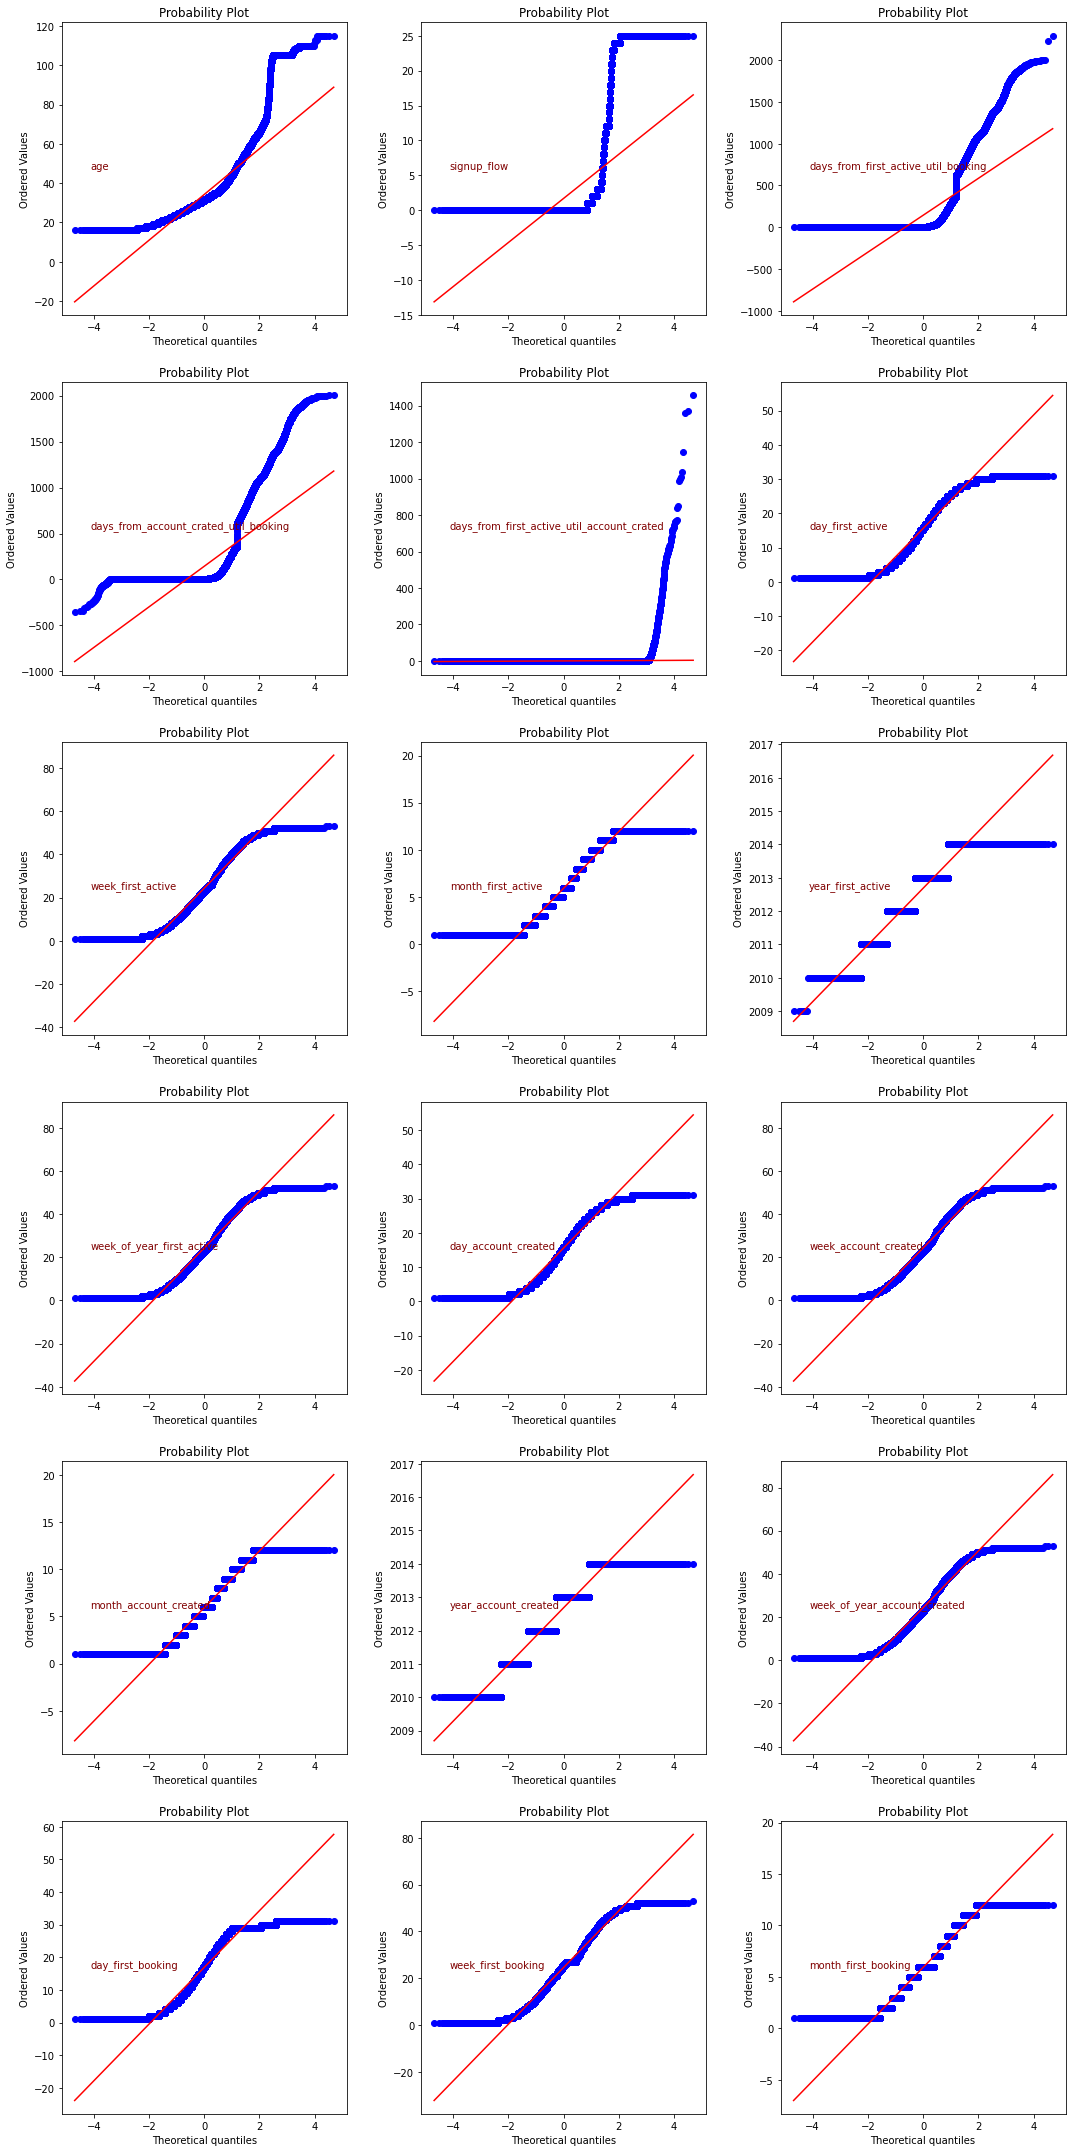

In [93]:
fig, ax = plt.subplots( 6, 3, figsize=(15, 30) )
ax = ax.flatten()
for i, c in zip( range(len(n_att_bl.columns)), n_att_bl.columns.tolist()[:18] ):
    ss.probplot( n_att_bl[c], plot=ax[i] )
    plt.tight_layout(w_pad=2., h_pad=2.)
    ax[i].text( .1, .5, c, color='maroon', transform=ax[i].transAxes)

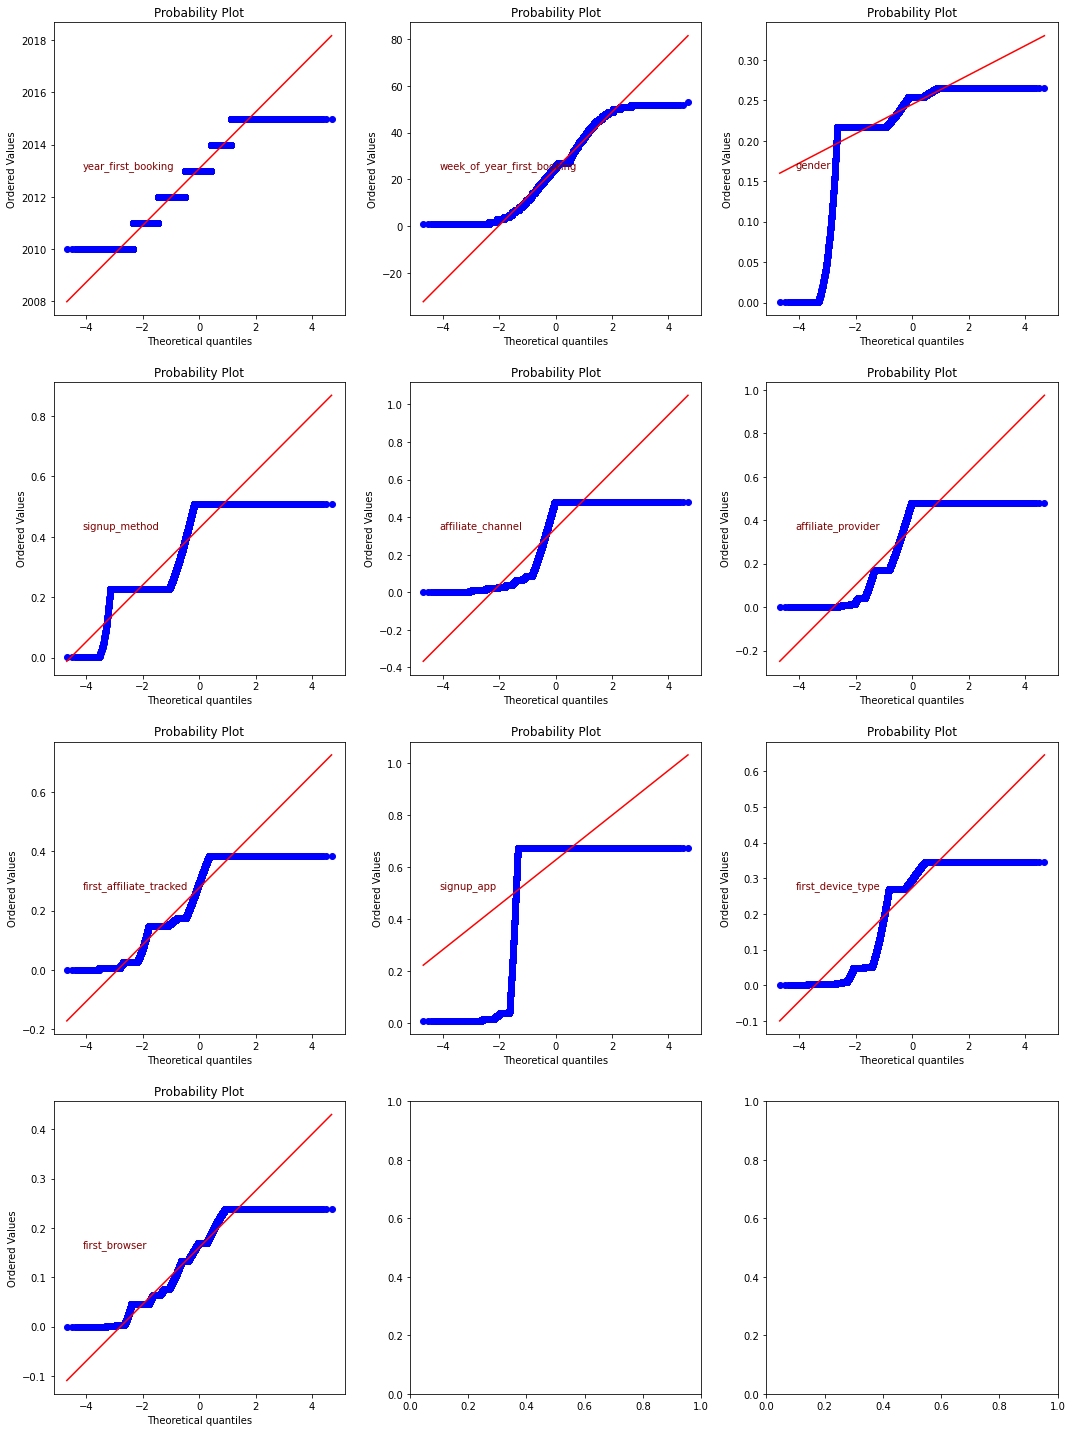

In [96]:
fig, ax = plt.subplots( 4, 3, figsize=(15, 20) )
ax = ax.flatten()
for i, c in zip( range(len(n_att_bl.columns)), n_att_bl.columns.tolist()[18:] ):
    ss.probplot( n_att_bl[c], plot=ax[i] )
    plt.tight_layout(w_pad=2., h_pad=2.)
    ax[i].text( .1, .5, c, color='maroon', transform=ax[i].transAxes)

#### 5.1.2.2. Numerical Variables (Sessions) 

array([[<AxesSubplot:title={'center':'secs_elapsed'}>]], dtype=object)

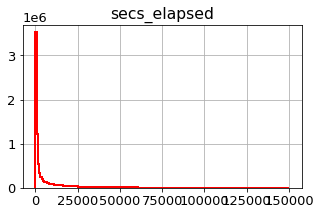

In [115]:
n_att_ss.hist(figsize=(5, 3), **args(bins=200))

### 5.1.3. Categorical Variables 

#### 5.1.3.1. Categorical Variables (Train Dataset)

In [131]:
c_att_un.describe()

,gender,signup_method,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,196118,196118,196118,196118,196118,196118,196118,196118,196118
unique,4,3,8,18,7,4,9,51,12
top,-unknown-,basic,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,82282,137447,126782,126557,103230,168970,85387,60889,111642


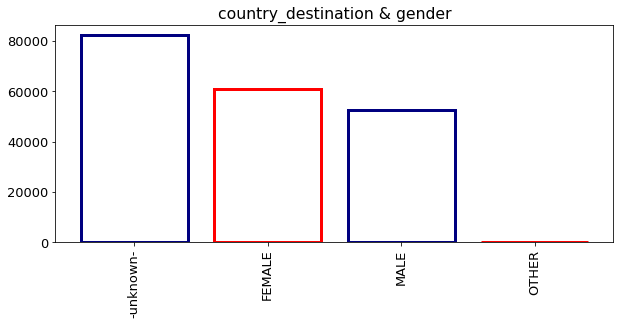

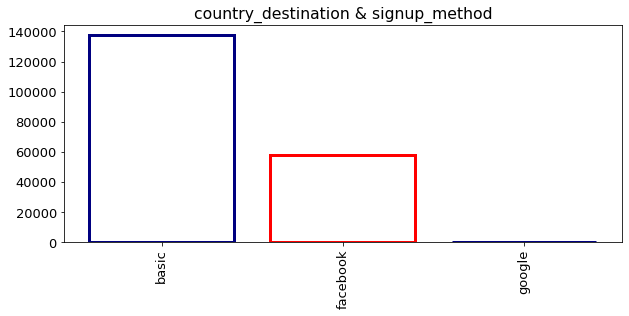

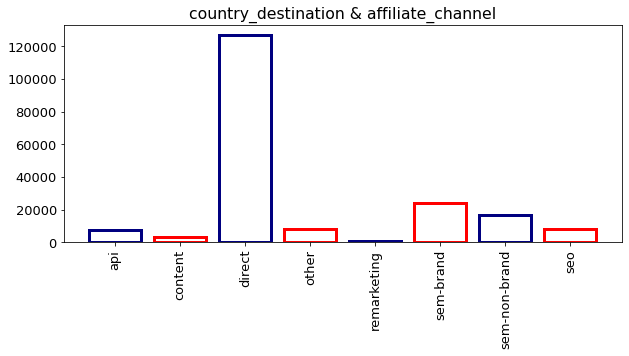

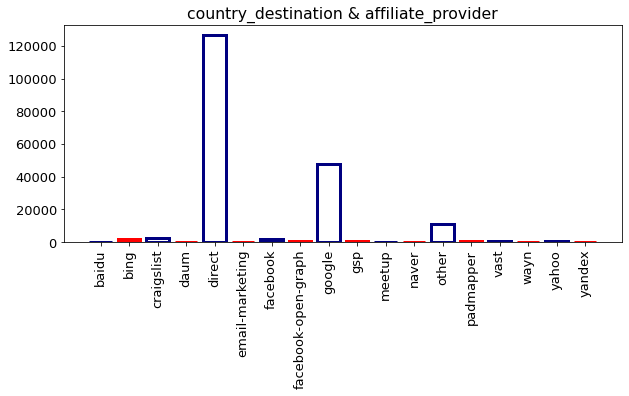

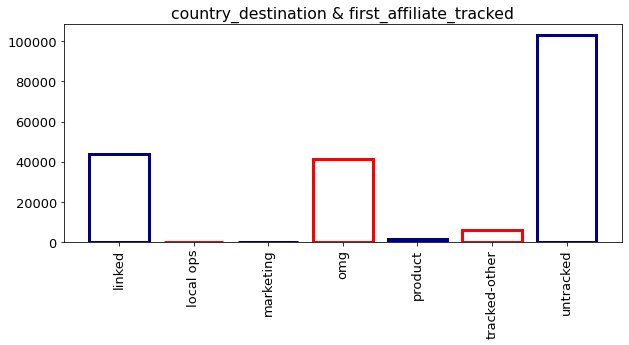

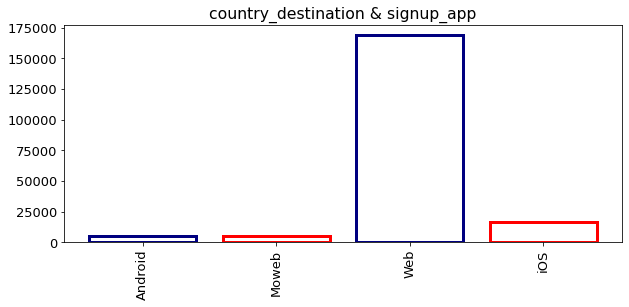

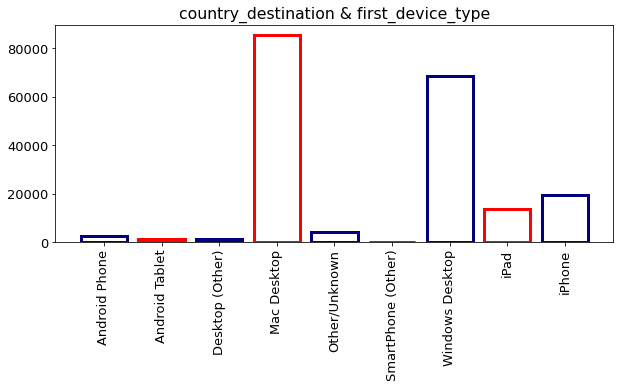

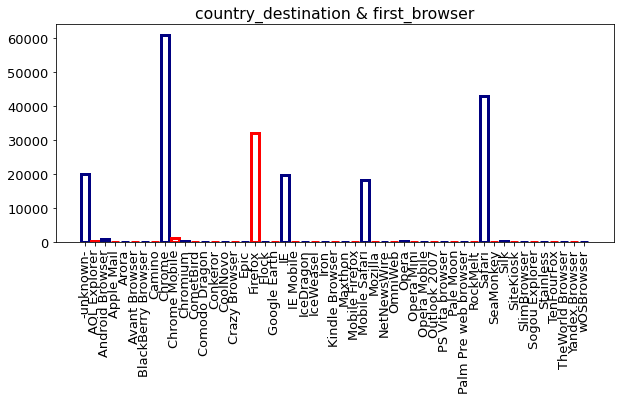

In [162]:
for i in c_att_un.columns.tolist()[:-1]:
    aux = c_att_un[['country_destination', i]].groupby(i).count().reset_index()
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(aux[i], aux.country_destination, **args_b())
    ax.set_title(f'country_destination & {i}')
    plt.xticks(rotation=90)

#### 5.1.3.2. Categorical Variables (Sessions)

In [128]:
c_att_ss = c_att_ss.drop('user_id', axis=1)
c_att_ss.describe()

,action,action_type,action_detail,device_type
count,8996196,8996196,8996196,8996196
unique,346,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2140856,3460431,1738048,2936131


## 5.2. Bivariate Analysis

### **H1.** Em todos os destinos, os usuários levam em média 15 dias para fazer a primeira reserva no Airbnb desde a primeira ativação.

**Verdadeiro** De acordo com a análise, em média os usuários levam em torno de 50 dias até o Booking, porém, como existe outliers, a melhor opção é a mediana, utilizando ela, os usuários levam até 5 dias para o booking.

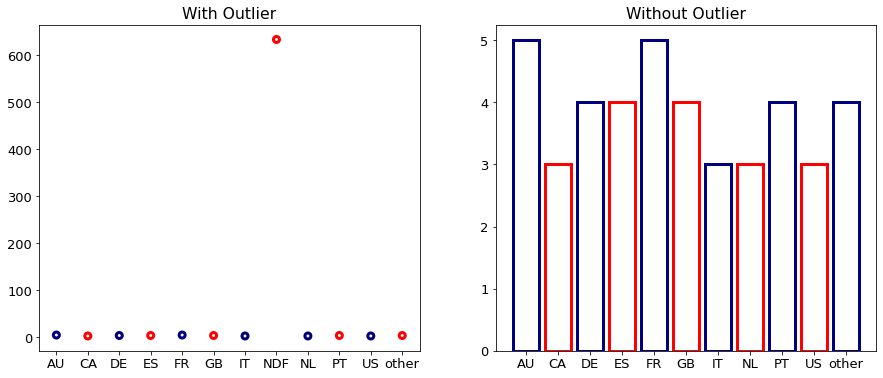

In [210]:
mp.plot_util_booking( df52, 'days_from_first_active_util_booking' )

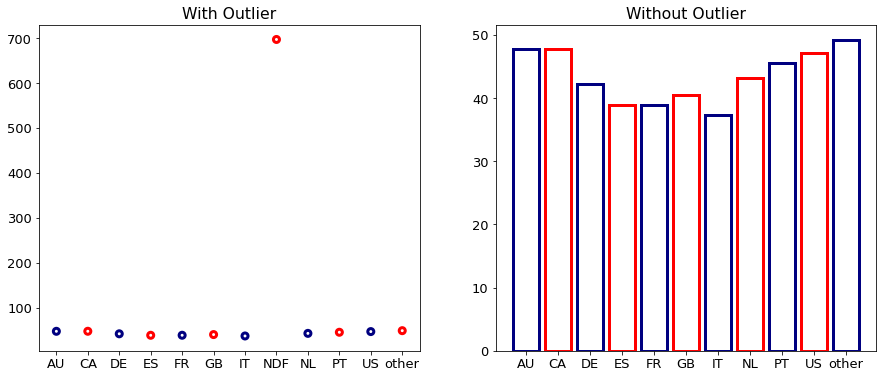

In [211]:
plot_util_booking( df52, 'days_from_first_active_util_booking', median=False )

### **H2.** Em todos os destinos, os usuários levam 3 dias em média para fazer o cadastro no site.

**Verdadeiro** Os usuários levam em média um dia para fazer o cadastro no site.

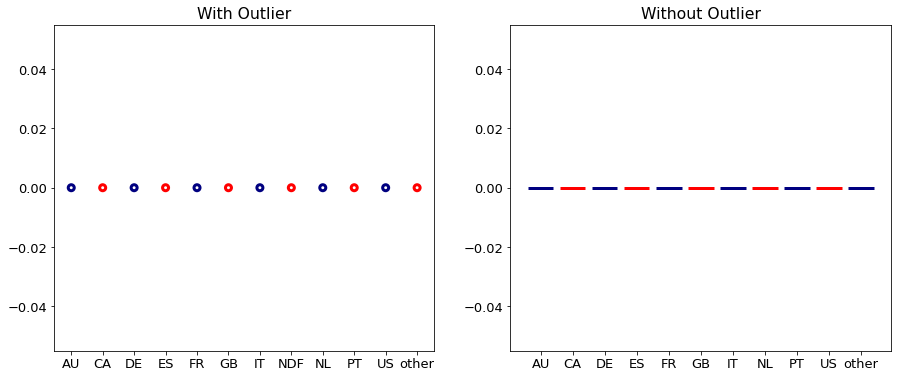

In [212]:
mp.plot_util_booking( df52, 'days_from_first_active_util_account_crated' )

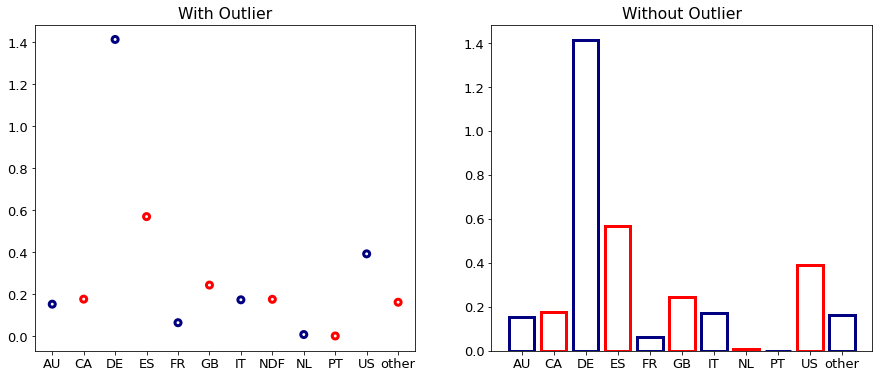

In [213]:
mp.plot_util_booking( df52, 'days_from_first_active_util_account_crated', median=False )

### **H3.** O volume de reservas anual feitas durante o verão aumentaram 20% para os destinos dentro dos EUA.

**Falsa** A porcentagem de reservas anuais no verão estão decrescendo.

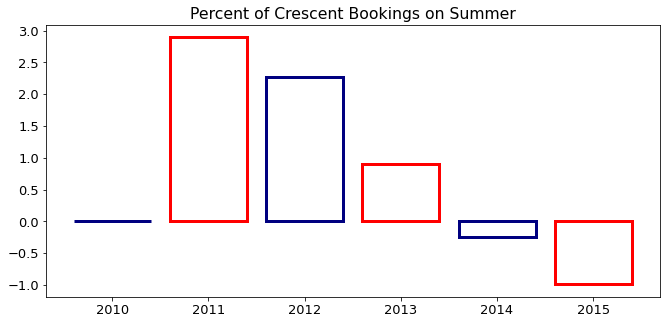

In [263]:
aux1 = df52[df52.country_destination == 'US']
aux1 = aux1[['country_destination', 'year_first_booking', 'month_first_booking']].groupby(['year_first_booking', 'month_first_booking', 'country_destination']).size().reset_index().rename(columns={0:'count'})

aux2 = aux1[aux1.month_first_booking.isin([6, 7, 8, 9])]
aux2 = aux2[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()
aux2['delta'] = aux2['count'].pct_change().fillna(0)

fig, ax = plt.subplots(figsize=(11, 5))
ax.bar( aux2['year_first_booking'], aux2['delta'], **args_b() );
ax.set_title('Percent of Crescent Bookings on Summer');

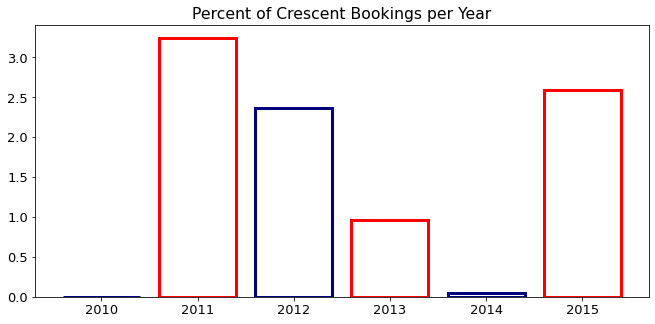

In [262]:
aux1 = df52[['country_destination', 'year_first_booking', 'month_first_booking']].groupby(['year_first_booking', 'month_first_booking', 'country_destination']).size().reset_index().rename(columns={0:'count'})
aux2 = aux1[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()
aux2['delta'] = aux2['count'].pct_change().fillna(0)

fig, ax = plt.subplots(figsize=(11, 5))
ax.bar( aux2['year_first_booking'], aux2['delta'], **args_b() );
ax.set_title('Percent of Crescent Bookings per Year');

### **H4.** Usuários do sexo feminino fazem 10% mais reservas para paises fora dos EUA.

**Verdadeira** Na verdade fazem mais de 20% de bookings.

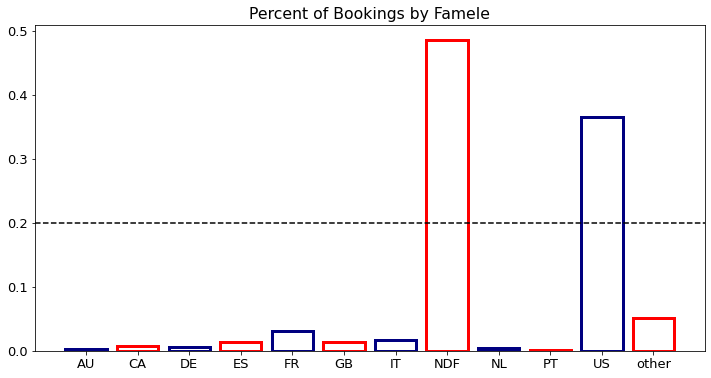

In [361]:
aux1 = df52[df52.gender == 'FEMALE']
aux2 = aux1[['gender', 'country_destination']].groupby('country_destination').count().reset_index()
aux2.gender = (aux2.gender / aux2.gender.sum()).apply( lambda x: np.round(x, 4))

mp.plot_percent(aux2, 'gender', .2, 'Percent of Bookings by Famele')

### **H5.** O canal de Marketing Google representa 40% de reservas para paises fora dos EUA.

**Falso** Apenas para locais não determinados.

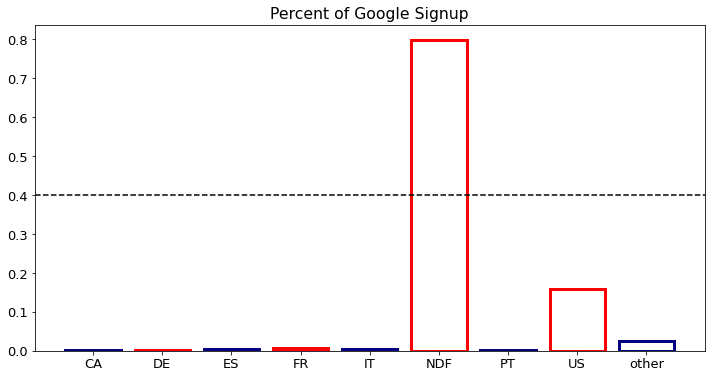

In [465]:
aux1 = df52[df52.signup_method == 'google']
aux1 = aux1[['signup_method', 'country_destination']].groupby(['signup_method', 'country_destination']).size().reset_index().rename(columns={0:'count'})
aux1['count'] = aux1['count'] / aux1['count'].sum()

mp.plot_percent(aux1, 'count', .4, 'Percent of Google Signup')

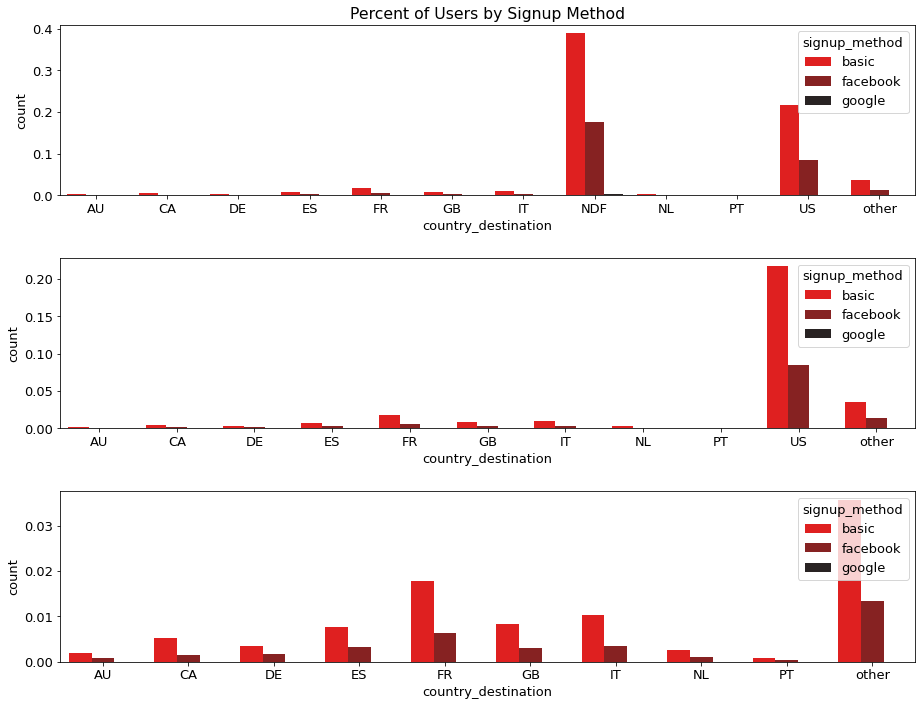

In [464]:
aux1 = df52[['signup_method', 'country_destination']].groupby(['signup_method', 'country_destination']).size().reset_index().rename(columns={0:'count'})
aux1['count'] = aux1['count'] / aux1['count'].sum()
aux2 = aux1[aux1.country_destination != 'NDF']
aux3 = aux1[(aux1.country_destination != 'NDF') & (aux1.country_destination != 'US')]

fig, ax = plt.subplots( 3, 1, figsize=(13, 10))
ax[0].set_title('Percent of Users by Signup Method');
for d, i in zip( [aux1, aux2, aux3], range( 0, 3 )):
    sns.barplot(x='country_destination', y='count', hue='signup_method', data=d, ax=ax[i], palette=palette);
plt.tight_layout(w_pad=1., h_pad=2.)

### **H6.** O Destino USA representa mais de 20% em todos os canais.

**Verdadeiro** US representa mais de .2% em todos os canais de afiliados.

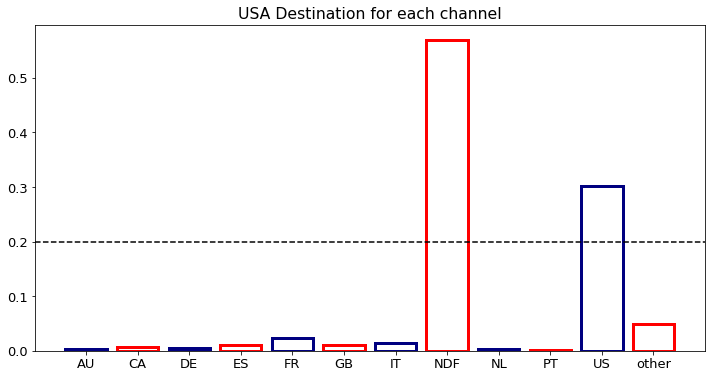

In [360]:
aux1 = df52[['country_destination', 'affiliate_channel']].groupby('country_destination').count().reset_index()
aux1.affiliate_channel = np.round((aux1.affiliate_channel / aux1.affiliate_channel.sum()), 3)

mp.plot_percent(aux1, 'affiliate_channel', .2, 'USA Destination for each channel')

### **H7.** A idade média das pessoas é de 35 anos em todos os destinos.

**Verdadeira** Aproximadamente a idade é de 35 ou próximo em todos os paises. 

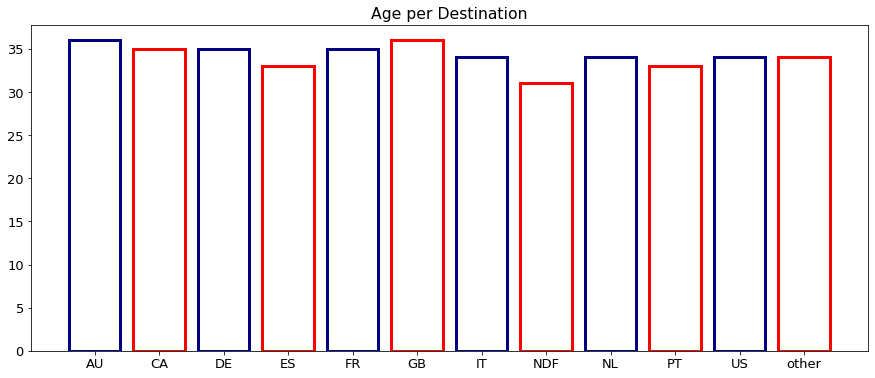

In [371]:
aux1 = df52[['country_destination', 'age']].groupby('country_destination').mean().reset_index()
aux1.age = aux1.age.apply(lambda x: int(x))

plt.bar(aux1.country_destination, aux1.age, **args_b())
plt.title('Age per Destination');

### <s>**H8.** A porcentagem de usuários que usam o site na lingua inglês-americano para reservar acomodações em qualquer destino é maior que 90% </s>

### **H9.** O Número de reservas do Airbnb é percentualmente crescente ao longo dos anos.

**Verdadeiro** Teve um decaimento percentual geral até 2014, mas em 2015 teve um aumento percentual novamente em relação a 2014.

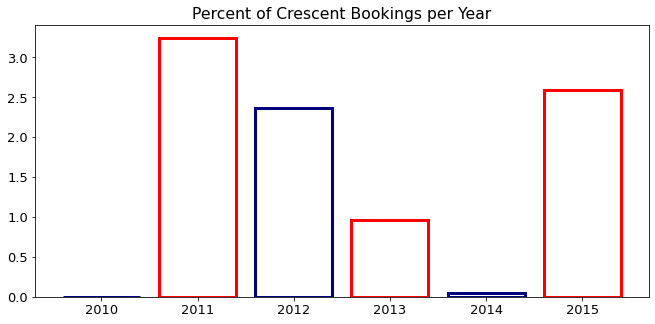

In [374]:
aux1 = df52[['country_destination', 'year_first_booking', 'month_first_booking']].groupby(['year_first_booking', 'month_first_booking', 'country_destination']).size().reset_index().rename(columns={0:'count'})
aux2 = aux1[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()
aux2['delta'] = aux2['count'].pct_change().fillna(0)

fig, ax = plt.subplots(figsize=(11, 5))
ax.bar(aux2['year_first_booking'], aux2['delta'], **args_b() );
ax.set_title('Percent of Crescent Bookings per Year');

### <s>**H10.** 75% das pessoas que deram feedbacks positivos retornaram para mais uma reserva. </s>

## 5.3. Multivariable Analysis

### 5.3.1. Numerical Variables

#### 5.3.1.1. Numerical Variables (Train Dataset)

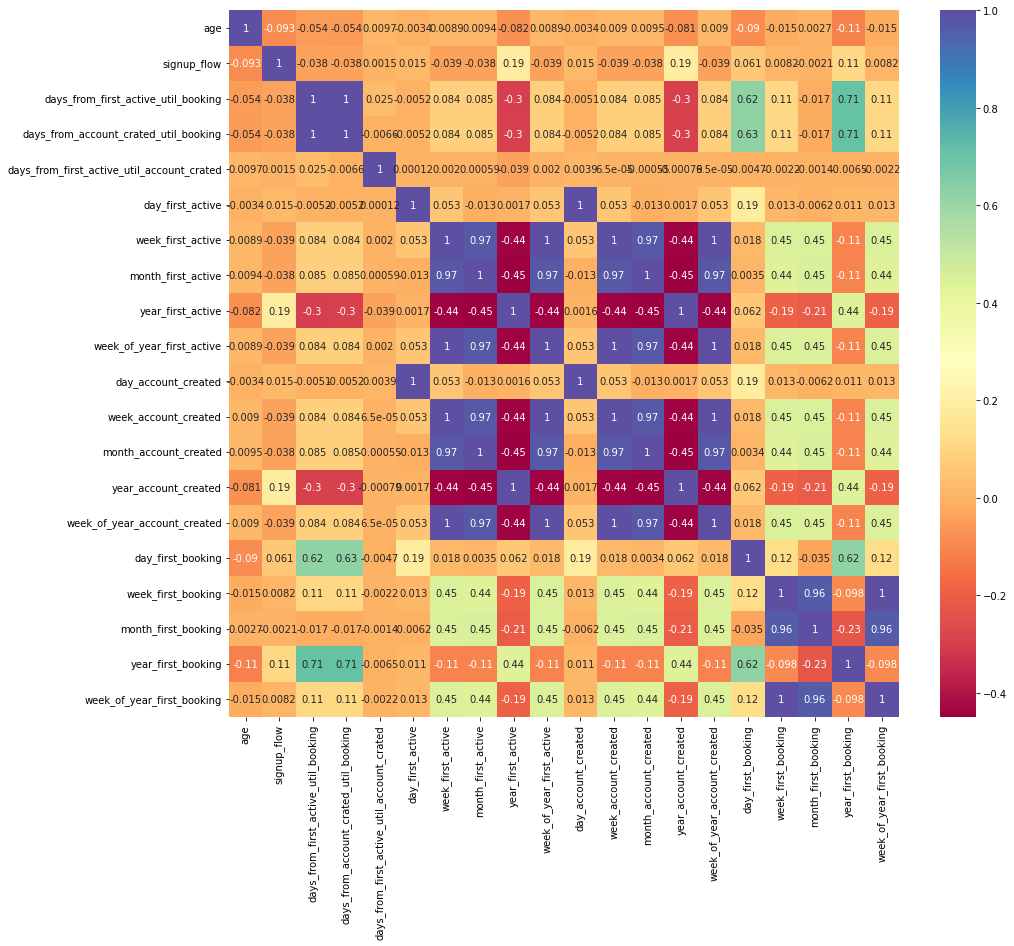

In [409]:
plt.rcParams['figure.figsize'] = [15, 13]
sns.heatmap( n_att_un.corr( method='pearson' ), annot=True, cmap='Spectral' );

#### 5.3.1.2. Numerical Variables (Session Dataset)

Only have Secs Elapsed

### 5.3.2. Categorical Variables

#### 5.3.2.1. Categorical Variables (Train Dataset)

In [396]:
# First Crisp
results = []
for i in c_att_un.columns:
    new_list = []
    for j in c_att_un.columns:
        new_list.append( mp.cramer_v( c_att[i], c_att[j]) )
    results.append(new_list)
    
c_corr = pd.DataFrame( results )
c_corr.columns = c_att.columns
c_corr = c_corr.set_index( c_att.columns )

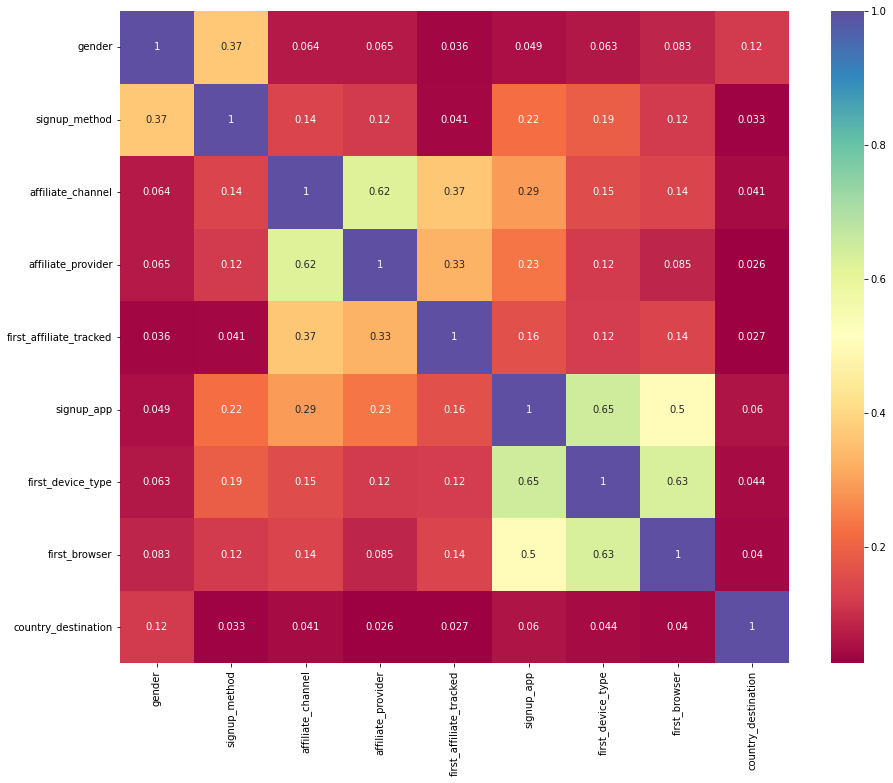

In [411]:
sns.heatmap( c_corr, annot=True, cmap='Spectral' );

In [70]:
# Second Crisp
#c_att_un = c_att_un.drop('id', axis=1)
results = []
for i in c_att_un.columns:
    new_list = []
    for j in c_att_un.columns:
        new_list.append( mp.cramer_v( c_att_un[i], c_att_un[j]) )
    results.append(new_list)
    
c_corr = pd.DataFrame( results )
c_corr.columns = c_att_un.columns
c_corr = c_corr.set_index( c_att_un.columns )

<AxesSubplot:>

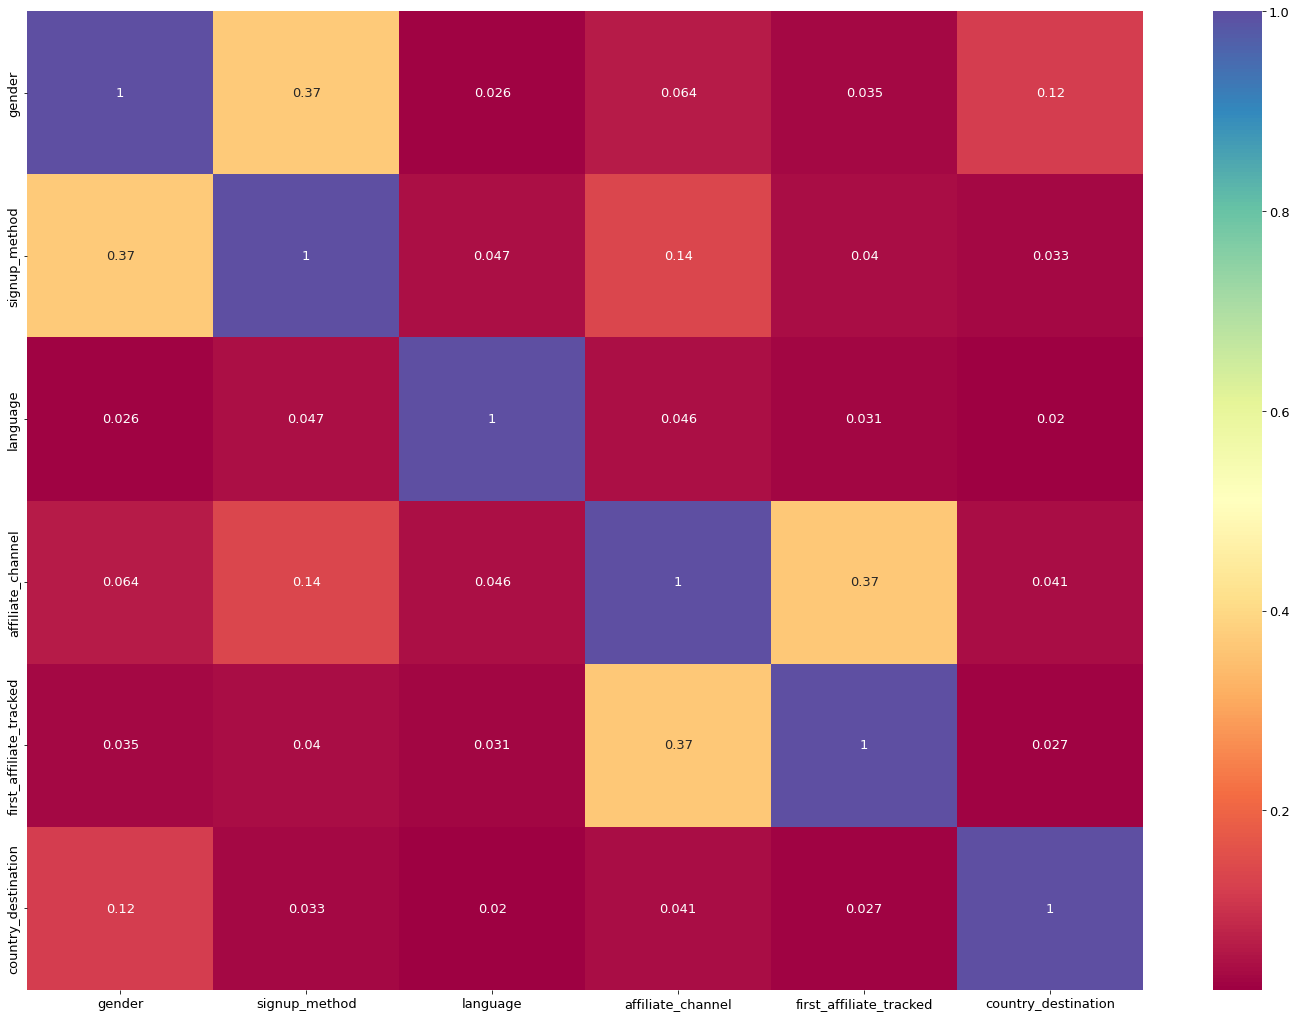

In [72]:
sns.heatmap( c_corr, annot=True, cmap='Spectral' )

#### 5.3.2.2. Categorical Variables (Session Dataset)

In [427]:
results = []
for k in c_att_ss.columns:
    new_list = []
    for j in c_att_ss.columns:
        new_list.append( mp.cramer_v(df_ses[k], df_ses[j] ) )
    results.append(new_list)

c_corr_s = pd.DataFrame( results )
c_corr_s.columns = c_att_ss.columns
c_corr_s = c_corr_s.set_index( c_att_ss.columns )

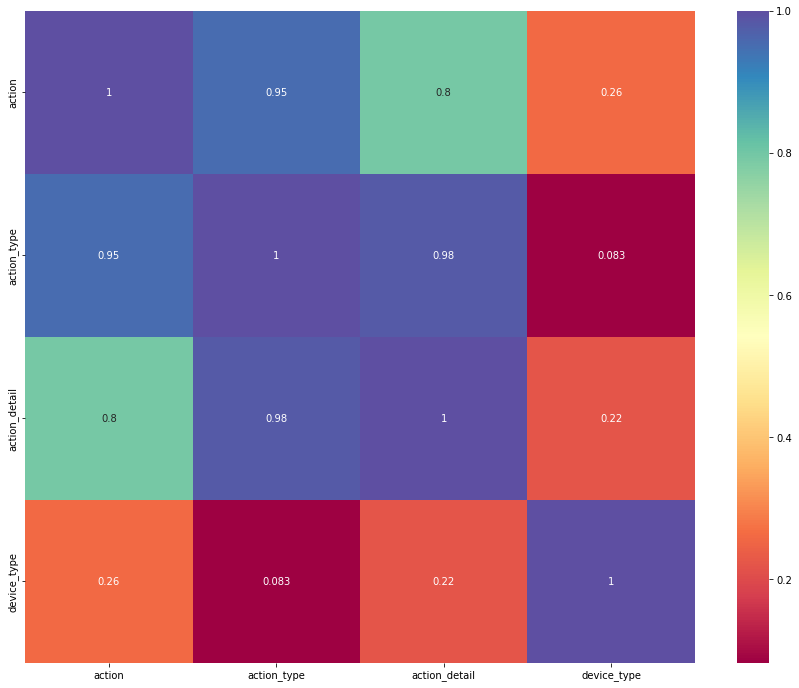

In [432]:
sns.heatmap( c_corr_s, annot=True, cmap='Spectral' );

In [434]:
c_att_ss.describe()

,action,action_type,action_detail,device_type
count,8996196,8996196,8996196,8996196
unique,346,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2140856,3460431,1738048,2936131


## 5.4. EDA Results

**Univariable Analisys**
- The Dataset have some normal features.
- Secs Elapsed from Sessions dataset have high outliers.

**Bivariate Analysis**
- Users dont use Google to loggin in Airbnb.
- Users with mean take 40 days to reserve, but with median it takes around 5 days.
- The percentage of new bookings remains constant up to a certain period in relation to the percentage of previous bookings. 

**List of Correlated Features / Drop Features**:

**Train Dataset:**<br>
Categorical Features: affliate_provider, first_browser, first_device_type<br>
Numerical Features: Some Correlated Feature Engineering Dataset

**Session Dataset:**<br>
Categorical Features: action, action_detail<br>
Numerical Features: //

# 6.0. Data Preparation

In [4]:
# First Cycles
# df61 = pd.read_csv('../data_backup/df3.csv')
# df62 = pd.read_csv('../data_backup/df3_balanced.csv')

# df61 = df61.drop('Unnamed: 0', axis=1)
# df62 = df62.drop('Unnamed: 0', axis=1)

# cols = ['days_from_first_active_util_booking',  'year_first_active',  'month_first_active', 'day_first_active',
#         'week_of_year_first_active', 'month_first_booking', 'month_account_created', 'week_of_year_account_created',
#         'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider', 'week_account_created',
#         'first_browser', 'first_device_type']

# df62 = df62.drop( columns=cols, axis=1 )

In [347]:
df_sen = pd.read_csv('../data_backup/df_senn.csv')
df_stk = pd.read_csv('../data_backup/df_stomek.csv')
df_sen = df_sen.drop('Unnamed: 0', axis=1)
df_stk = df_stk.drop('Unnamed: 0', axis=1)

## 6.1. Rescaling

In [83]:
rs = RobustScaler()
mms = MinMaxScaler()

In [7]:
df62.age = mms.fit_transform( df62[['age']].values )
df62.signup_flow = rs.fit_transform( df62[['signup_flow']].values )
df62.year_account_created = mms.fit_transform( df62[['year_account_created']].values )
df62.days_from_account_crated_util_booking = rs.fit_transform( df62[['days_from_account_crated_util_booking']].values )
df62.days_from_first_active_util_account_crated = mms.fit_transform( df62[['days_from_first_active_util_account_crated']].values )

## 6.2. Rescaling (Smoteen, Smotetomek)

In [84]:
# SMOTEEN
df_sen.age = mms.fit_transform( df_sen[['age']].values )
df_sen.signup_flow = rs.fit_transform( df_sen[['signup_flow']].values )
df_sen.year_account_created = mms.fit_transform( df_sen[['year_account_created']].values )
df_sen.days_from_account_crated_util_booking = rs.fit_transform( df_sen[['days_from_account_crated_util_booking']].values )
df_sen.days_from_first_active_util_account_crated = mms.fit_transform( df_sen[['days_from_first_active_util_account_crated']].values )

In [85]:
# SMOTETOMEKLINKS
df_stk.age = mms.fit_transform( df_stk[['age']].values )
df_stk.signup_flow = rs.fit_transform( df_stk[['signup_flow']].values )
df_stk.year_account_created = mms.fit_transform( df_stk[['year_account_created']].values )
df_stk.days_from_account_crated_util_booking = rs.fit_transform( df_stk[['days_from_account_crated_util_booking']].values )
df_stk.days_from_first_active_util_account_crated = mms.fit_transform( df_stk[['days_from_first_active_util_account_crated']].values )

In [348]:
# Save on Pickle
df_sen.age = mms.fit_transform( df_sen[['age']].values )
pickle.dump( mms, open( 'age_scaler.pkl', 'wb' ) )

df_sen.signup_flow = rs.fit_transform( df_sen[['signup_flow']].values )
pickle.dump( rs, open( 'signup_flow_scaler.pkl', 'wb' ) )

df_sen.year_account_created = mms.fit_transform( df_sen[['year_account_created']].values )
pickle.dump( mms, open( 'year_account_created_scaler.pkl', 'wb' ) )

df_sen.days_from_account_crated_util_booking = rs.fit_transform( df_sen[['days_from_account_crated_util_booking']].values )
pickle.dump( rs, open( 'days_from_account_crated_util_booking_scaler.pkl', 'wb' ) )

df_sen.days_from_first_active_util_account_crated = mms.fit_transform( df_sen[['days_from_first_active_util_account_crated']].values )
pickle.dump( mms, open( 'days_from_first_active_util_account_crated_scaler.pkl', 'wb' ) )


## 6.3. Encoding

## 6.3. Nature Transformation

In [8]:
df62['week_first_active_sin']   = df62['week_first_active'].apply( lambda x: np.sin( x *( 2 * np.pi / 7 ) ) )
df62['week_first_active_cos']   = df62['week_first_active'].apply( lambda x: np.cos( x *( 2 * np.pi / 7 ) ) )
df62['day_first_booking_sin']   = df62['day_first_booking'].apply( lambda x: np.sin( x *( 2 * np.pi / 31) ) )
df62['day_first_booking_cos']   = df62['day_first_booking'].apply( lambda x: np.cos( x *( 2 * np.pi / 31) ) )
df62['week_first_booking_sin']  = df62['week_first_booking'].apply( lambda x: np.sin( x *( 2 * np.pi / 7) ) )
df62['week_first_booking_cos']  = df62['week_first_booking'].apply( lambda x: np.cos( x *( 2 * np.pi / 7) ) )
df62['day_account_created_sin'] = df62['day_account_created'].apply(lambda x: np.sin( x *( 2 * np.pi / 31 ) ) )
df62['day_account_created_cos'] = df62['day_account_created'].apply(lambda x: np.cos( x *( 2 * np.pi / 31 ) ) )

## 6.4. Neature Transformation (Smoteen, Smotetomek)

In [86]:
for df in [df_sen, df_stk]:
    df['week_first_active_sin']   = df['week_first_active'].apply( lambda x: np.sin( x *( 2 * np.pi / 7 ) ) )
    df['week_first_active_cos']   = df['week_first_active'].apply( lambda x: np.cos( x *( 2 * np.pi / 7 ) ) )
    df['day_first_booking_sin']   = df['day_first_booking'].apply( lambda x: np.sin( x *( 2 * np.pi / 31) ) )
    df['day_first_booking_cos']   = df['day_first_booking'].apply( lambda x: np.cos( x *( 2 * np.pi / 31) ) )
    df['week_first_booking_sin']  = df['week_first_booking'].apply( lambda x: np.sin( x *( 2 * np.pi / 7) ) )
    df['week_first_booking_cos']  = df['week_first_booking'].apply( lambda x: np.cos( x *( 2 * np.pi / 7) ) )
    df['day_account_created_sin'] = df['day_account_created'].apply(lambda x: np.sin( x *( 2 * np.pi / 31 ) ) )
    df['day_account_created_cos'] = df['day_account_created'].apply(lambda x: np.cos( x *( 2 * np.pi / 31 ) ) )

In [89]:
df_sen.to_csv('../data_backup/df_sen.csv')
df_stk.to_csv('../data_backup/df_stk.csv')

# <font color='red'> 7.0. Feature Space Plots </font>

**Next Steps for Cycle 3**

## 7.1. PCA Embedding

## 7.2. UMAP Embedding

## 7.3. t-SNE Embedding

## 7.4. Tree-Based Embedding

# 8.0. Feature Selection

In [99]:
# df62 = df62.drop( columns=['week_first_active', 'day_first_booking', 'week_first_booking', 'day_account_created', 'signup_flow', 'signup_app', 'days_from_first_active_util_account_crated'], axis=1 )
# X = df62.drop('country_destination', axis=1)
# y = df62.country_destination

# Second Cycle
df_sen = pd.read_csv('../data_backup/df_sen.csv')
df_stk = pd.read_csv('../data_backup/df_stk.csv')
df_sen = df_sen.drop('Unnamed: 0', axis=1)
df_stk = df_stk.drop('Unnamed: 0', axis=1)

df_sen = df_sen[['age', 'signup_flow', 'days_from_account_crated_util_booking', 'days_from_first_active_util_account_crated', 'week_first_active', 'day_account_created', 'year_account_created', 'day_first_booking', 'week_first_booking', 'gender', 'signup_method', 'language', 'affiliate_channel', 'first_affiliate_tracked', 'week_first_active_sin', 'week_first_active_cos', 'day_first_booking_sin', 'day_first_booking_cos', 'week_first_booking_sin', 'week_first_booking_cos', 'day_account_created_sin', 'day_account_created_cos', 'country_destination']]
df_stk = df_stk[['age', 'signup_flow', 'days_from_account_crated_util_booking', 'days_from_first_active_util_account_crated', 'week_first_active', 'day_account_created', 'year_account_created', 'day_first_booking', 'week_first_booking', 'gender', 'signup_method', 'language', 'affiliate_channel', 'first_affiliate_tracked', 'week_first_active_sin', 'week_first_active_cos', 'day_first_booking_sin', 'day_first_booking_cos', 'week_first_booking_sin', 'week_first_booking_cos', 'day_account_created_sin', 'day_account_created_cos', 'country_destination']]

X_sen = df_sen.iloc[:, :-1]
y_sen = df_sen.iloc[:, -1]

X_stk = df_stk.iloc[:, :-1]
y_stk = df_stk.iloc[:, -1]

x_train_sen, x_valid_sen, y_train_sen, y_valid_sen = train_test_split( X_sen, y_sen, test_size=.15 )
x_train_stk, x_valid_stk, y_train_stk, y_valid_stk = train_test_split( X_stk, y_stk, test_size=.15 )

In [198]:
df_sen

,age,signup_flow,days_from_account_crated_util_booking,days_from_first_active_util_account_crated,week_first_active,day_account_created,year_account_created,day_first_booking,week_first_booking,gender,...,first_affiliate_tracked,week_first_active_sin,week_first_active_cos,day_first_booking_sin,day_first_booking_cos,week_first_booking_sin,week_first_booking_cos,day_account_created_sin,day_account_created_cos,country_destination
0,0.212121,2.0,-0.038961,0.0,28,13,0.00,14,28,0.216093,...,0.384704,-9.797174e-16,1.000000,0.299363,-0.954139,-9.797174e-16,1.000000,0.485302,-0.874347,AU
1,0.282828,2.0,0.298701,0.0,28,17,0.00,8,36,0.216093,...,0.384704,-9.797174e-16,1.000000,0.998717,-0.050649,7.818315e-01,0.623490,-0.299363,-0.954139,AU
2,0.171717,3.0,-0.045455,0.0,45,9,0.00,9,45,0.253162,...,0.173053,4.338837e-01,-0.900969,0.968077,-0.250653,4.338837e-01,-0.900969,0.968077,-0.250653,AU
3,0.141414,3.0,-0.045455,0.0,45,10,0.00,10,45,0.266135,...,0.384704,4.338837e-01,-0.900969,0.897805,-0.440394,4.338837e-01,-0.900969,0.897805,-0.440394,AU
4,0.151515,2.0,-0.038961,0.0,47,28,0.00,29,48,0.266135,...,0.384704,-9.749279e-01,-0.222521,-0.394356,0.918958,-7.818315e-01,0.623490,-0.571268,0.820763,AU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398021,0.202020,0.0,-0.045455,0.0,19,8,0.75,9,19,0.266135,...,0.178230,-9.749279e-01,-0.222521,0.968077,-0.250653,-9.749279e-01,-0.222521,0.998717,-0.050649,other
398022,0.141414,0.0,-0.038961,0.0,20,15,0.75,16,20,0.219483,...,0.370367,-7.818315e-01,0.623490,-0.101168,-0.994869,-7.818315e-01,0.623490,0.101168,-0.994869,other
398023,0.111111,0.0,0.045455,0.0,9,25,1.00,11,11,0.253162,...,0.096347,9.749279e-01,-0.222521,0.790776,-0.612106,-4.338837e-01,-0.900969,-0.937752,0.347305,other
398024,0.101010,0.0,1.376623,0.0,14,2,0.75,7,45,0.255696,...,0.054926,-4.898587e-16,1.000000,0.988468,0.151428,4.338837e-01,-0.900969,0.394356,0.918958,other


## 8.1. Feature Importance

### 8.1.1. First Cycle 

In [131]:
xg = XGBClassifier( n_jobs=-1 ).fit( x_train.values, y_train.values )
rf = RandomForestClassifier( n_jobs=-1 ).fit( x_train.values, y_train.values )

imp_xg = mp.get_importance( x_train.columns, x_train, xg )
imp_rf = mp.get_importance( x_train.columns, x_train, rf )

[14:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


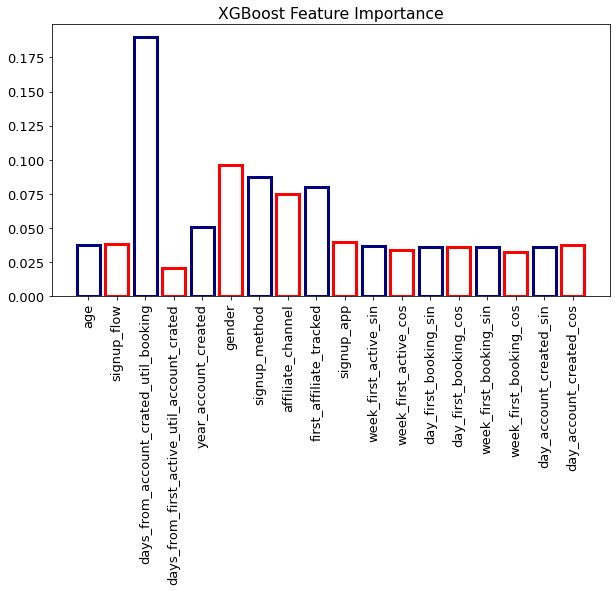

In [132]:
fig, ax = plt.subplots( figsize=(10, 5))
ax.bar( imp_xg.keys(), imp_xg.values(), **mp.args_b() )
ax.set_title('XGBoost Feature Importance')
plt.xticks( rotation=90);

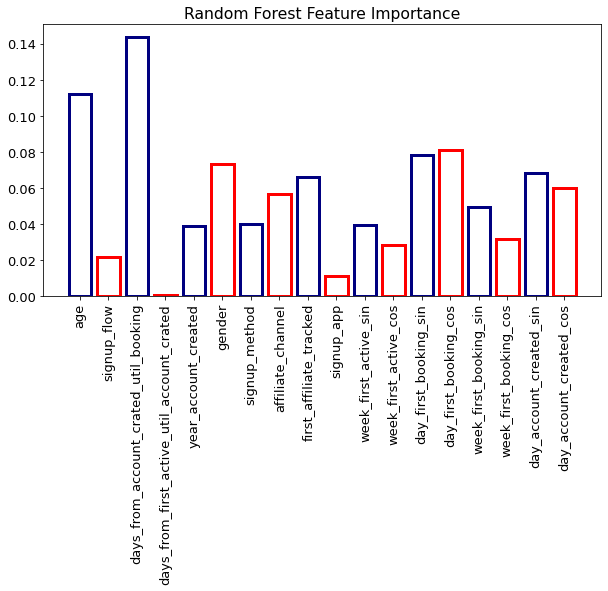

In [133]:
fig, ax = plt.subplots( figsize=(10, 5))
ax.bar( imp_rf.keys(), imp_rf.values(), **mp.args_b() )
ax.set_title('Random Forest Feature Importance')
plt.xticks( rotation=90);

### 8.1.2. Second Cycle 

##### 8.1.2.1. SMOTEEN

In [100]:
xg = XGBClassifier( n_jobs=-1 ).fit( x_train_sen.values, y_train_sen.values )
rf = RandomForestClassifier( n_jobs=-1 ).fit( x_train_sen.values, y_train_sen.values )

imp_xg = mp.get_importance( x_train_sen.columns, x_train_sen, xg )
imp_rf = mp.get_importance( x_train_sen.columns, x_train_sen, rf )

[15:09:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


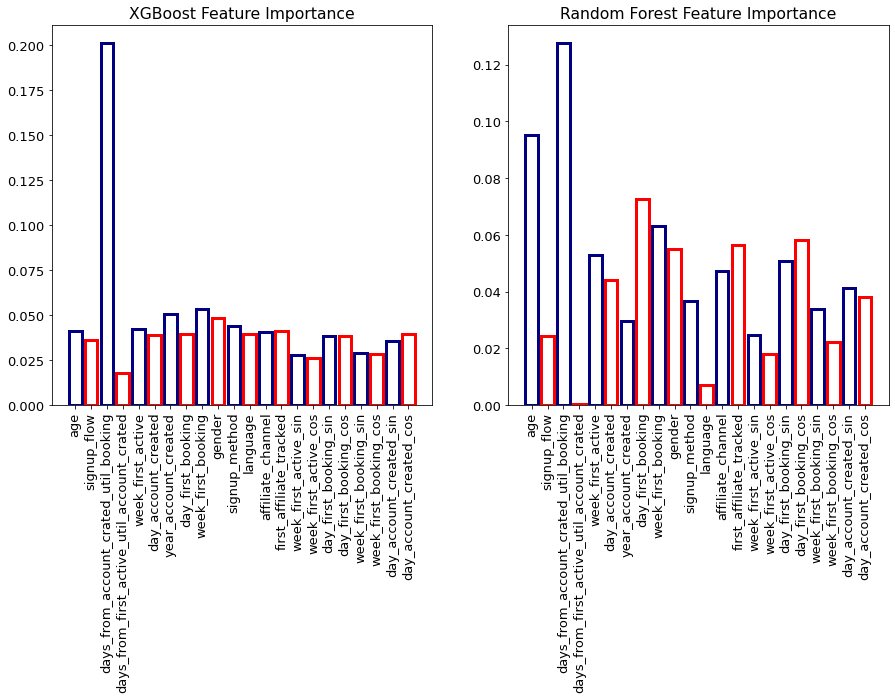

In [116]:
fig, ax = plt.subplots( 1, 2, figsize=(15, 7))
for i, l, d in zip( range(2), ['XGBoost Feature Importance', 'Random Forest Feature Importance'], [imp_xg, imp_rf] ):
    ax[i].bar( d.keys(), d.values(), **mp.args_b() )
    ax[i].set_title(l)
    ax[i].set_xticklabels( d.keys(), rotation = 90)

##### 8.1.2.1. SMOTETOMEKLINKS

In [117]:
xg = XGBClassifier( n_jobs=-1 ).fit( x_train_stk.values, y_train_stk.values )
rf = RandomForestClassifier( n_jobs=-1 ).fit( x_train_stk.values, y_train_stk.values )

imp_xg = mp.get_importance( x_train_stk.columns, x_train_stk, xg )
imp_rf = mp.get_importance( x_train_stk.columns, x_train_stk, rf )

[15:19:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


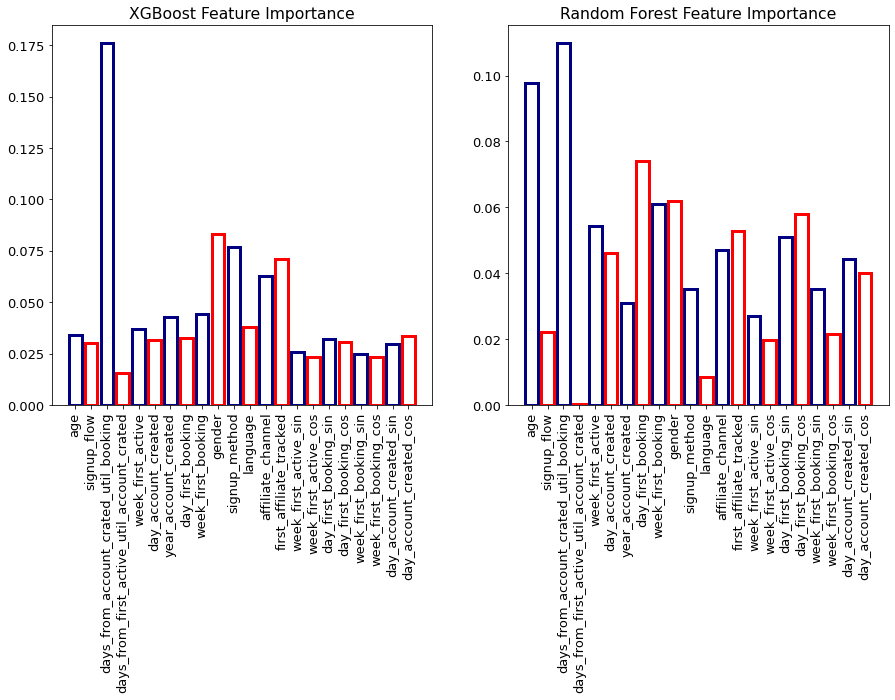

In [118]:
fig, ax = plt.subplots( 1, 2, figsize=(15, 7))
for i, l, d in zip( range(2), ['XGBoost Feature Importance', 'Random Forest Feature Importance'], [imp_xg, imp_rf] ):
    ax[i].bar( d.keys(), d.values(), **mp.args_b() )
    ax[i].set_title(l)
    ax[i].set_xticklabels( d.keys(), rotation = 90)

## 7.2. Boruta Feature Importance

Next Cycle

## 7.3. Features Resume

**Columns to drop**: signup_flow, signup_app, days_from_first_active_util_account_created //Language

# 9.0. Machine Learning Models

## 9.1. Baseline Model

In [42]:
k = y_test.shape[0]
c_list = df62.country_destination.drop_duplicates().sort_values().tolist()
weights = df62.country_destination.value_counts( normalize=True ).sort_index().tolist()

yhat_random = choices(population=c_list, weights=weights, k=k)

### 9.1.1. Baseline Performace

,Model Name,Accuracy,Balanced Accuracy,Kappa Score
0,Random Choices,0.085803,0.082603,-0.000919


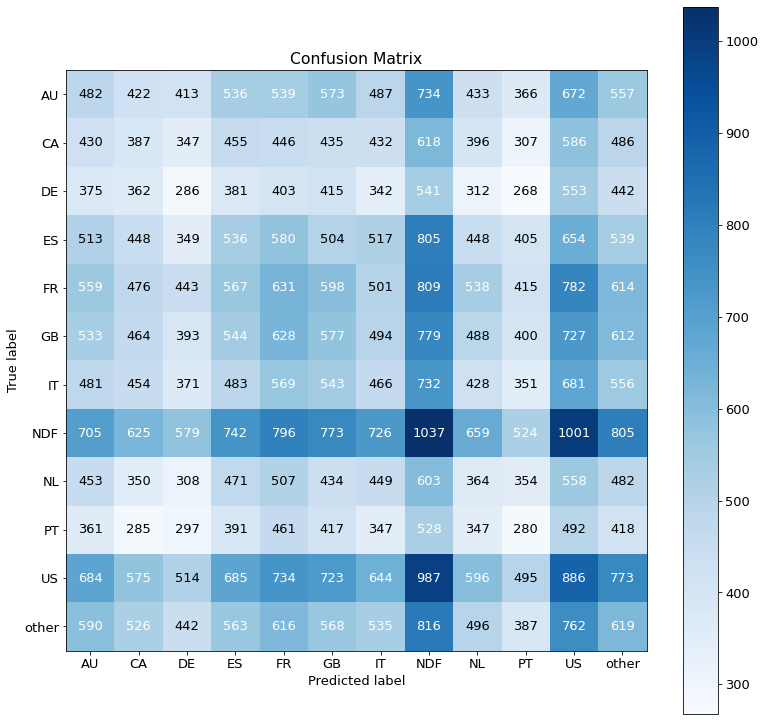

In [43]:
bs_res = mp.ml_error('Random Choices', y_valid, yhat_random)
bs_res

## 8.2. XGBoost Classifier

### 8.2.1. SMOTEEN Dataset

In [120]:
xgb = XGBClassifier( n_jobs=-1 ).fit( x_train_sen, y_train_sen )

yhat_xgb = xgb.predict( x_valid_sen )

[15:57:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### 8.2.1.1. XGBoost Performace

,Model Name,Accuracy,Balanced Accuracy,Kappa Score
0,XGBoost,0.673606,0.637969,0.640822


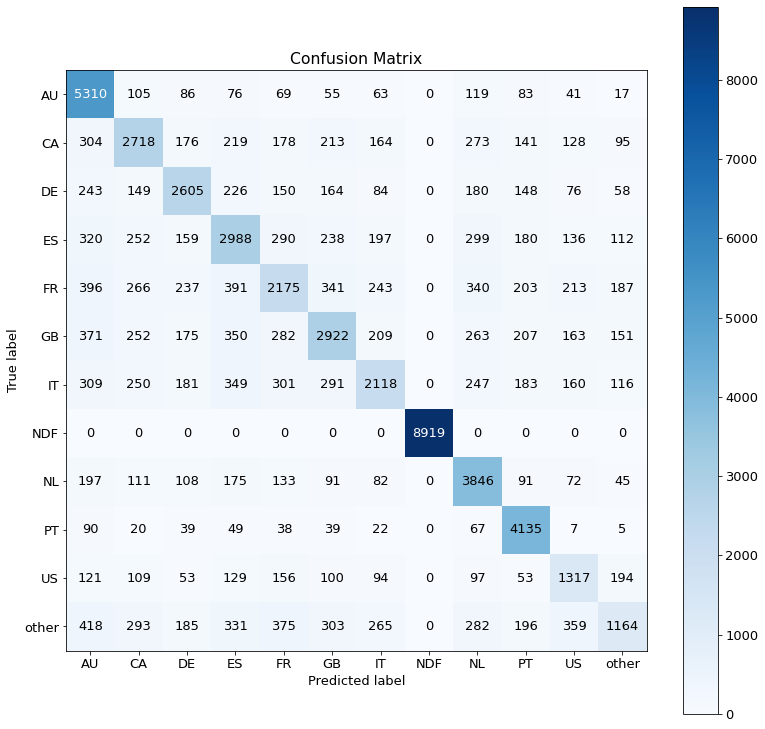

In [121]:
xg_res = mp.ml_error('XGBoost', y_valid_sen, yhat_xgb)
xg_res

### 8.2.2. SMOTETOMEKLINKS Dataset

In [135]:
xgb = XGBClassifier( n_jobs=-1 ).fit( x_train_stk, y_train_stk )

yhat_xgb = xgb.predict( x_valid_stk )

#### 8.2.2.1. XGBoost Performace

,Model Name,Accuracy,Balanced Accuracy,Kappa Score
0,XGBoost,0.627202,0.612568,0.5913


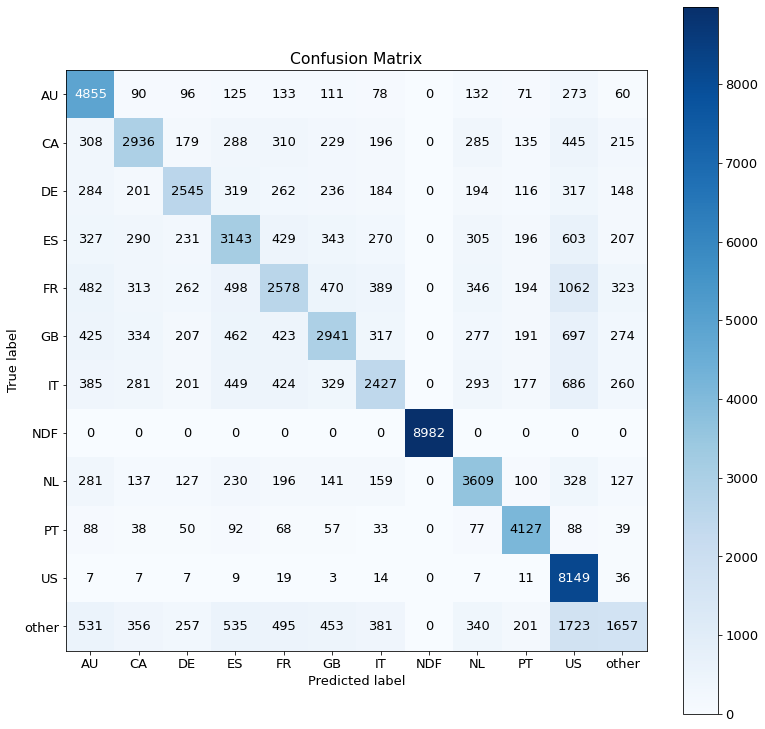

In [123]:
xg_res = mp.ml_error('XGBoost', y_valid_stk, yhat_xgb)
xg_res

## 8.3. Random Forest Classifier 

### 8.3.1. SMOTEEN Dataset

In [331]:
rf = RandomForestClassifier( n_jobs=-1 ).fit( x_train_sen, y_train_sen )

yhat_rf = rf.predict( x_valid_sen )

#### 8.3.1.1. Random Forest Performace

,Model Name,Accuracy,Balanced Accuracy,Kappa Score
0,Random Forest,0.956485,0.938542,0.952133


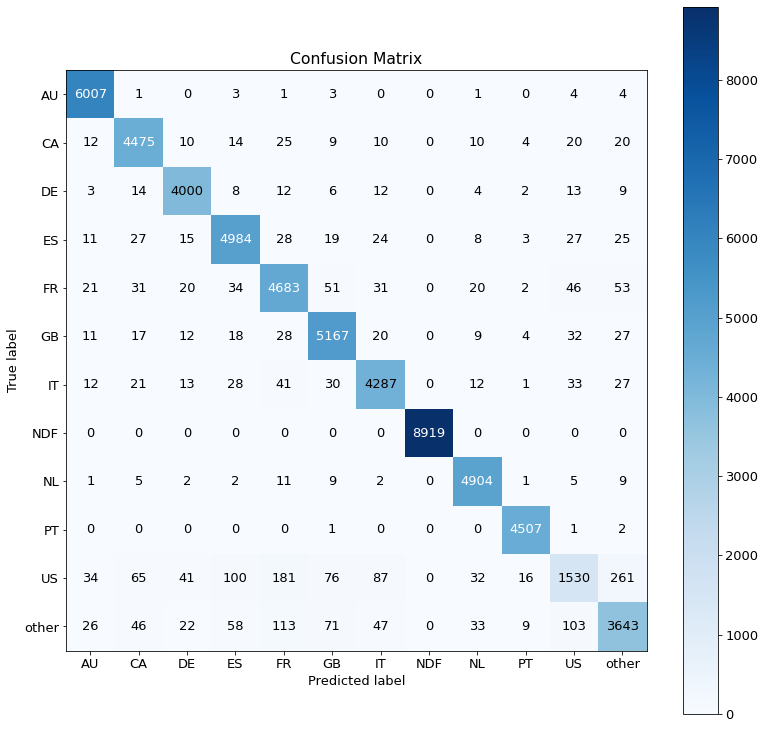

In [332]:
rf_res = mp.ml_error('Random Forest', y_valid_sen, yhat_rf)
rf_res

##### 8.3.1.2. Without columns -> language & days_from_first_active_util_account_created

In [141]:
x_train_sen_x = x_train_sen.drop( columns=['language', 'days_from_first_active_util_account_crated'], axis=1 )
x_valid_sen_x = x_valid_sen.drop( columns=['language', 'days_from_first_active_util_account_crated'], axis=1 )

In [147]:
rf = RandomForestClassifier( n_jobs=-1 ).fit( x_train_sen_x, y_train_sen )

yhat_rf = rf.predict( x_valid_sen_x )

,Model Name,Accuracy,Balanced Accuracy,Kappa Score
0,Random Forest,0.956519,0.938777,0.95217


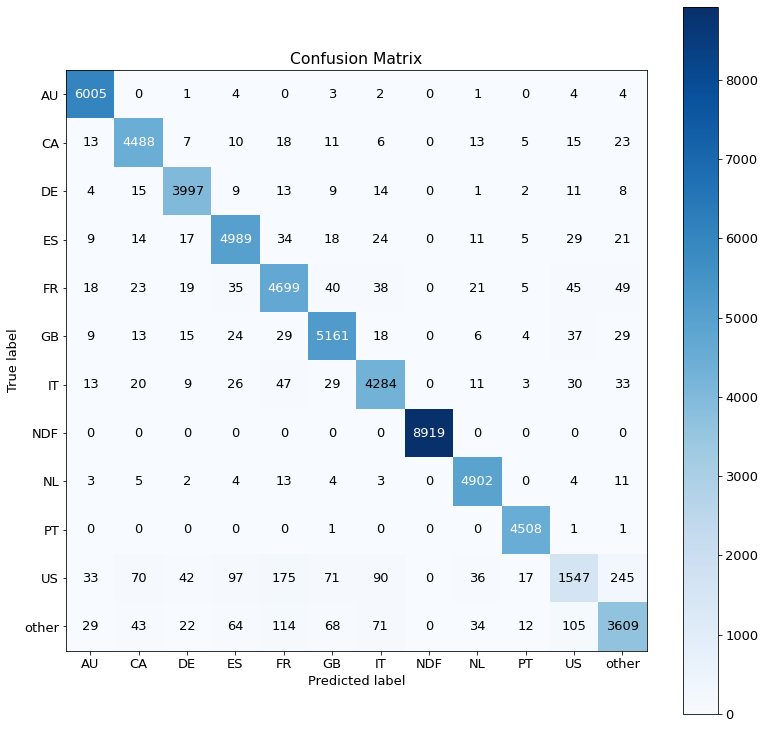

In [148]:
rf_res = mp.ml_error('Random Forest', y_valid_sen, yhat_rf)
rf_res

### 8.3.2. SMOTETOMEKLINKS Dataset

In [153]:
rf = RandomForestClassifier( n_jobs=-1 ).fit( x_train_stk, y_train_stk )

yhat_rf = rf.predict( x_valid_stk )

#### 8.3.2.1. Random Forest Performace

,Model Name,Accuracy,Balanced Accuracy,Kappa Score
0,Random Forest,0.91945,0.92218,0.911771


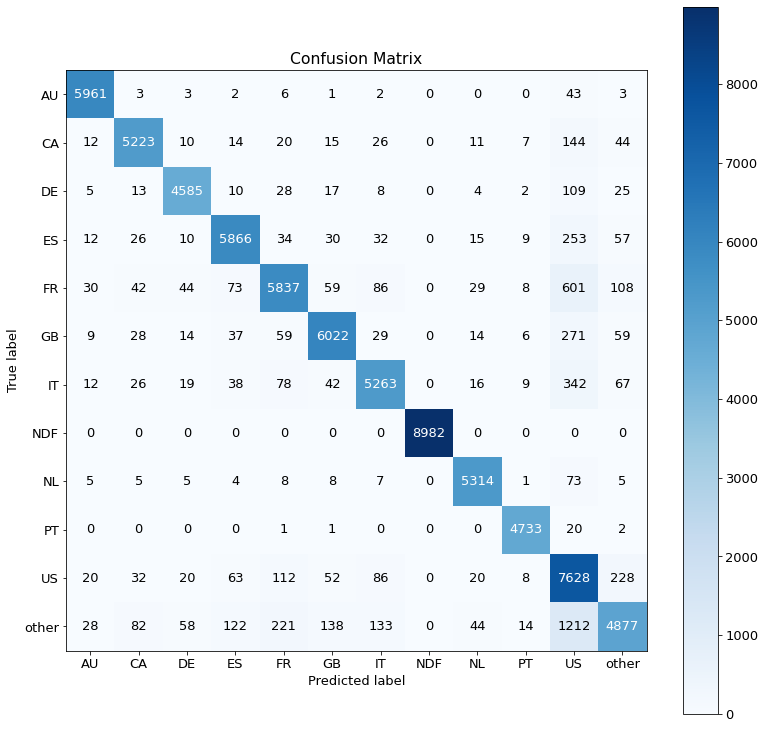

In [154]:
rf_res = mp.ml_error('Random Forest', y_valid_stk, yhat_rf )
rf_res

## 8.4. Neural Network

In [53]:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1, 1) ).toarray()
y_valid_nn = ohe.fit_transform( y_valid.values.reshape(-1, 1) ).toarray()

In [54]:
model = tf.keras.Sequential()
model.add( tf.keras.layers.Dense( 64, input_dim=x_train.shape[1], activation='relu' ) )
model.add( tf.keras.layers.Dense( len(y_test.unique()), activation='softmax') )

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                1024      
                                                                 
 dense_3 (Dense)             (None, 12)                780       
                                                                 
Total params: 1,804
Trainable params: 1,804
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(x_train, y_train_nn, epochs=100, verbose=1, validation_data=(x_valid, y_valid_nn))

_, train_acc = model.evaluate( x_train, y_train_nn, verbose=0 )
_, valid_acc = model.evaluate( x_valid, y_valid_nn, verbose=0 )

# Next Cycles
#yhat_nn = model.predict( x_valid )
#yhat_nn = ohe.inverse_transform( yhat_nn )
#y_valid_nn = y_test.to_numpy()
#yhat_nn = yhat_nn.reshape( 1, -1 )[0]

### 8.3.1. Neural Network Performace

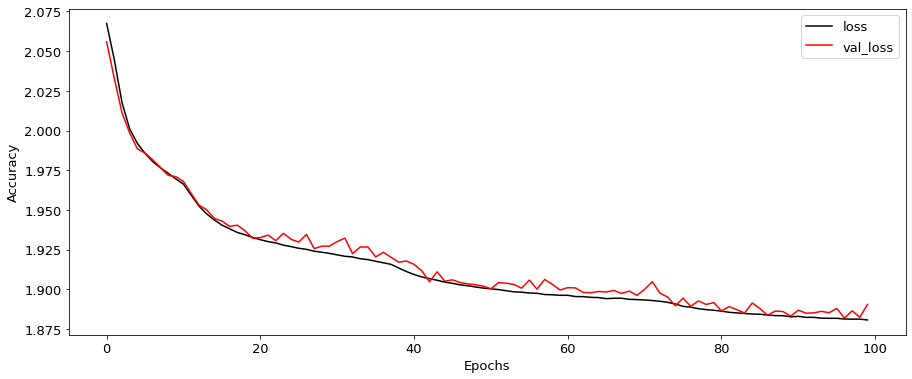

In [71]:
plt.plot( history.history['loss'], label='loss', c='k' )
plt.plot( history.history['val_loss'], label='val_loss', c='r' )
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [68]:
nn_res = pd.DataFrame( {'Model Name': 'Neural Network', 'Train Acc': train_acc, 'Valid Acc': valid_acc}, index=[0] )

nn_res

,Model Name,Train Acc,Valid Acc
0,Neural Network,0.342029,0.339664


# 10.0. Hyperparameter Tuning

## 9.1. Default Model Stratified Cross Validation

### 9.1.1. Random Forest Smoteen 

In [317]:
cross_rf_sen, ac, kp = mp.cross_validation('Random Forest (SEN)', RandomForestClassifier(n_jobs=-1), x_train_sen, y_train_sen)
cross_rf_sen

,Model Name,Kappa Score,Balanced Acc
0,Random Forest (SEN),0.9389 +/- 0.0002,0.9246 +/- 0.0004


### 9.1.2. Random Forest Smotetomeklink 

In [159]:
cross_rf_sen, _, _ = mp.cross_validation('Random Forest (STK)', RandomForestClassifier(n_jobs=-1), x_train_stk, y_train_stk)
cross_rf_sen

,Model Name,Kappa Score,Balanced Acc
0,Random Forest (STK),0.8982 +/- 0.0006,0.9095 +/- 0.0006


## 9.2. Random Search Hyperparameter Tuning

In [179]:
params = { 
    'n_estimators': [75, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [15, 20, 30, 40, 50, 60, 70]
}

In [180]:
mean_bal = []
std_bal  = []

for i in range( 50 ):
    hp = {k: sample( v, 1 ) for k, v in params.items()}
    print(hp, file=open('tuning.txt', 'a'))
    
    rf = RandomForestClassifier( n_jobs=-1,
                                 criterion= hp['criterion'][0],
                                 max_depth = hp['max_depth'][0] )
    
    results_tun = mp.cross_validation('Random Forest', rf, x_train_sen, y_train_sen);
    print(results_tun[0].T.to_dict()[0], file=open('tuning.txt', 'a'))
    print('\n', file=open('tuning.txt', 'a'))
    
    mean_bal.append( float(results_tun[0]['Balanced Acc'][0][:6]) )
    std_bal.append( float(results_tun[0]['Balanced Acc'][0][11:]) )

,Model Name,Accuracy,Balanced Accuracy,Kappa Score
0,RF Tunned,0.957122,0.939763,0.952835


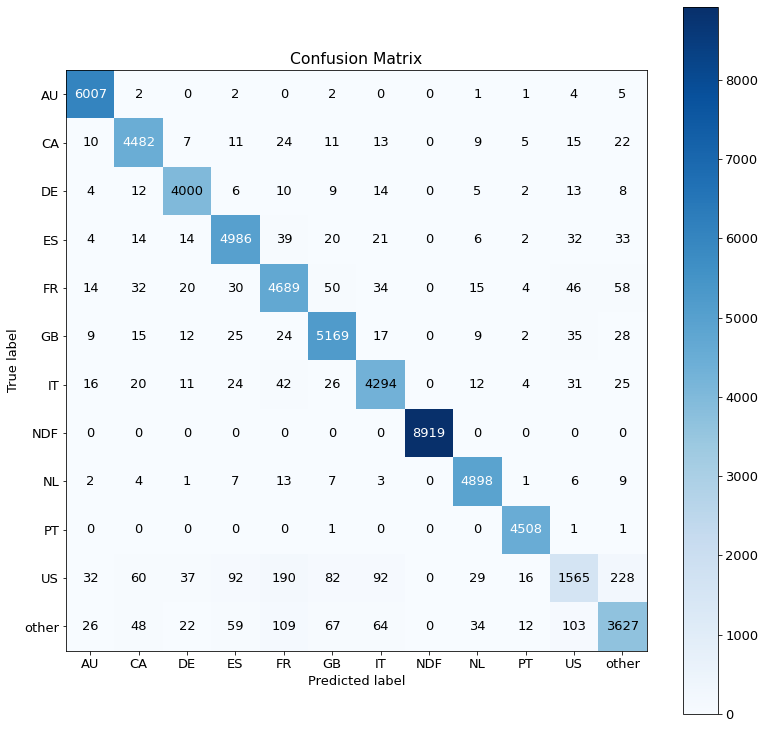

In [325]:
params_best = {'n_estimators': 75, 'criterion': 'gini', 'max_depth': 60}

rfc_tnn = RandomForestClassifier( n_jobs=-1,
                                  max_depth = params_best['max_depth'],
                                  criterion = params_best['criterion'] ).fit( x_train_sen, y_train_sen )

yhat_tnn = rfc_tnn.predict( x_valid_sen )

rf_results = mp.ml_error('RF Tunned', y_valid_sen, yhat_tnn)
rf_results

,Model Name,Accuracy,Balanced Accuracy,Kappa Score
0,RF Tunned,0.919567,0.922196,0.911896


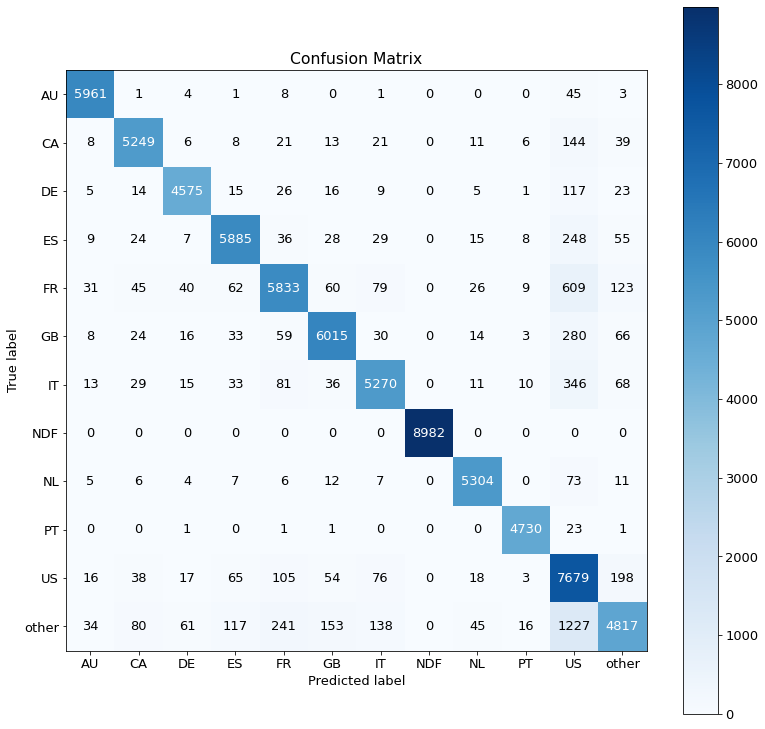

In [324]:
params_best = {'n_estimators': 75, 'criterion': 'gini', 'max_depth': 60}

rfc_tnn = RandomForestClassifier( n_jobs=-1,
                                  max_depth = params_best['max_depth'],
                                  criterion = params_best['criterion'] ).fit( x_train_stk, y_train_stk )

yhat_tnn = rfc_tnn.predict( x_valid_stk )

rf_results = mp.ml_error('RF Tunned', y_valid_stk, yhat_tnn)
rf_results

## 9.3. Random Cross Validation Tuned

In [195]:
geral_results = mp.cross_validation('Random Forest', rfc_tnn,  x_train_sen, y_train_sen );
geral_results[0]

,Model Name,Kappa Score,Balanced Acc
0,Random Forest,0.8982 +/- 0.0007,0.9094 +/- 0.0006


In [196]:
geral_results = mp.cross_validation('Random Forest', rfc_tnn,  x_train_stk, y_train_stk );
geral_results[0]

,Model Name,Kappa Score,Balanced Acc
0,Random Forest,0.8982 +/- 0.0007,0.9094 +/- 0.0006


## 9.4. Bootstrap Confidence Intervals

In [199]:
data = df_sen.values

In [216]:
n_inter = 1000
stats = []
i = 0

for i in range(n_inter):
    print(f'Inter: {i}')
    train = resample( data, n_samples=int(len(df_sen) * .30))
    #test = np.array([x for x in data if x.tolist() not in train.tolist()])
    
    rfc_tnn.fit(train[:, :-1], train[:, -1])
    yhat = rfc_tnn.predict(x_valid_sen.values)
    
    acc = balanced_accuracy_score( y_valid_sen.values, yhat )
    stats.append( acc )
    i+=1

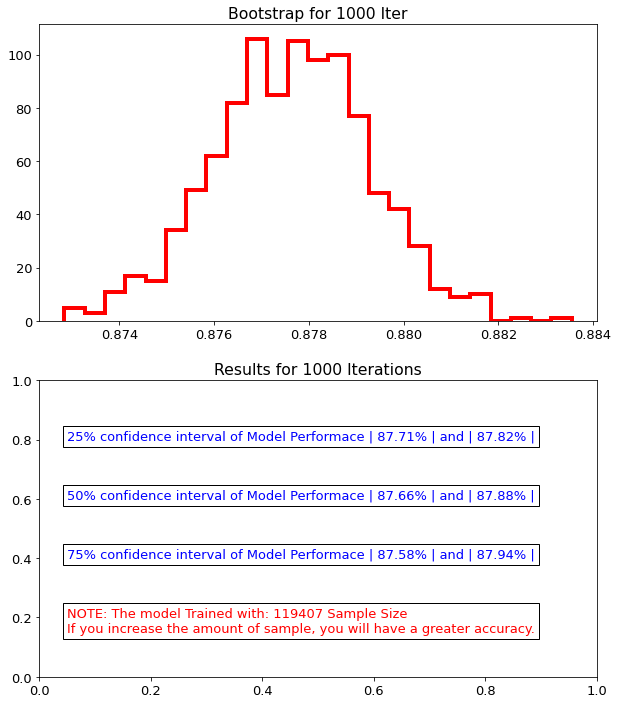

In [315]:
text = f'NOTE: The model Trained with: {len(train)} Sample Size\nIf you increase the amount of sample, you will have a greater accuracy.'
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].hist(stats, **mp.args(bins=25, lwidth=4));
ax[0].set_title(f'Bootstrap for {n_inter} Iter');
for i in zip( [.25, .50, .75], [.8, .6, .4] ):
    a = i[0]
    p_l = ((1.-a)/2.) * 100
    p_u = (a+((1.-a)/2.)) * 100
    lower = np.percentile(stats, p_l)
    upper = np.percentile(stats, p_u)
    
    text2 = f'{int(a*100)}% confidence interval of Model Performace | {np.round(lower*100, 2)}% | and | {np.round(upper*100, 2)}% |'
    ax[1].text( .05, i[1], text2, bbox={'facecolor': 'white'}, transform=ax[1].transAxes, color='b');
    
ax[1].text( .05, .15, text, bbox={'facecolor': 'white'}, transform=ax[1].transAxes, color='red');
ax[1].set_title(f'Results for {n_inter} Iterations');

plt.savefig('b_results.png')

In [327]:
pickle.dump( rfc_tnn, open( 'random_forest.pkl', 'wb') )

In [336]:
pickle.dump( rf, open('pure_rf.pkl', 'wb'))

# 11.0. Model Bussiness Results

## 11.1. XGBoost Geral Performace

1. With 100 Bootstrap interations of XGBoost & confidence interval of .75, the model have a prob of 75% to be good on 54.7 / 55.3 true model performace.
2. Cross Validation for XGBoost: Kappa Score with Mean (0.5396) +/- Std (0.0016) and Balanced Accuracy with Mean(0.5571) +/- Std (0.0016) for 5 Kfold Validations.
3. The Model Have a Good Performace on 'NDF' country destination class, have some factors for this, the customers comportaments are different from other based on EDA and have much more Examples of this On Dataset.

In [269]:
# Set Differences (If Negative: Model Wrong More for this class )
abs_perfm_au  = 4534 - (580+502+573+681+611+652+0+439+226+1+747)
abs_perfm_ca  = 2248 - (73+137+166+197+201+211+0+109+60+1+241)
abs_perfm_de  = 2098 - (85+160+164+189+195+175+0+123+42+0+203)
abs_perfm_es  = 2935 - (203+335+331+476+458+532+0+256+129+1+527)
abs_perfm_fr  = 2596 - (220+467+397+540+494+637+0+297+117+0+619)
abs_perfm_gb  = 2783 - (181+310+298+384+472+461+0+205+118+0+489)
abs_perfm_it  = 1710 - (89+213+145+199+245+233+0+120+60+0+261)
abs_perfm_ndf = 8964 - (3+4+3+2+1+4+6+4+0+19+5)
abs_perfm_nl  = 3179 - (93+196+170+232+209+205+201+0+79+1+276)
abs_perfm_pt  = 3566 - (96+157+123+168+168+214+197+0+103+3+184)
abs_perfm_us  = 8198 - (392+539+369+698+1052+750+754+0+380+175+1700)
abs_perfm_oth = 1637 - (155+359+214+415+490+364+449+0+185+69+3)

In [270]:
print(f'Total of Users on Dataset: {len(df62)}')
print(f'Total of Unique Rows on Dataset: {len(df62.drop_duplicates())}\n')

for k, v in y_train.value_counts().to_dict().items():
    print(f'Total Destination Per Unique Users: | {k} -> {v} |')

Total of Users on Dataset: 508991
Total of Unique Rows on Dataset: 490961

Total Destination Per Unique Users: | NDF -> 51034 |
Total Destination Per Unique Users: | US -> 46991 |
Total Destination Per Unique Users: | FR -> 39075 |
Total Destination Per Unique Users: | other -> 39075 |
Total Destination Per Unique Users: | GB -> 37244 |
Total Destination Per Unique Users: | ES -> 35788 |
Total Destination Per Unique Users: | AU -> 35011 |
Total Destination Per Unique Users: | IT -> 33479 |
Total Destination Per Unique Users: | NL -> 30726 |
Total Destination Per Unique Users: | CA -> 30565 |
Total Destination Per Unique Users: | DE -> 27121 |
Total Destination Per Unique Users: | PT -> 26533 |


In [319]:
d = {}
for v, c in zip( [abs_perfm_au, abs_perfm_ca, abs_perfm_de, abs_perfm_es, abs_perfm_fr, abs_perfm_gb, abs_perfm_it, abs_perfm_ndf, abs_perfm_nl, abs_perfm_pt, abs_perfm_us, abs_perfm_oth], 
                  df62.country_destination.drop_duplicates().sort_values() ):
    keys_values = {c: v}
    d.update(keys_values)

In [328]:
pd.DataFrame( d, index=[0] ).style.highlight_min(axis=1, color='#8ab7ff')

,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
0,-478,852,762,-313,-1192,-135,145,8913,1517,2153,1389,-1066


1. **NDF** and **Pt** have great results with this model.
2. **Fr** and **Other** have Worst results with this model.
3. All other destination is +/- Random.

## 11.2. Random Forest Geral Performace

1. With 1000 Bootstrap interations of Random Forest with 119407 sample size, the model have a prob of 75% to be good on the 87.58 and 87.94 true model performace. (Tunned Model its more simple Model) 
2. Cross Validation for Random Forest: Kappa Score with Mean (0.9389) +/- Std (0.0002) and Balanced Accuracy with Mean (0.9246)  +/- Std (0.0004) for 5 Kfold Validations. (Normal Random Forest Model)

I have selected standart random forest because its very simple and get good results on dataset used SMOTEEN.

In [341]:
# Set Differences for Random Forest
abs_perfm_au  = 6007 - (12+3+11+21+11+12+0+1+0+34+26)
abs_perfm_ca  = 4475 - (1+14+27+31+17+21+0+5+0+65+46)
abs_perfm_de  = 4000 - (0+10+15+20+12+13+0+2+0+41+22)
abs_perfm_es  = 4984 - (3+14+8+34+18+28+0+0+2+100+58)
abs_perfm_fr  = 4683 - (1+25+12+28+28+41+0+11+0+181+113)
abs_perfm_gb  = 5167 - (3+9+6+19+51+30+0+9+1+76+71)
abs_perfm_it  = 4287 - (0+10+12+24+31+20+0+2+0+87+47)
abs_perfm_ndf = 8919
abs_perfm_nl  = 4904 - (1+10+4+8+20+9+12+0+0+32+33)
abs_perfm_pt  = 4507 - (0+4+2+3+2+4+1+0+1+16+9)
abs_perfm_us  = 1530 - (4+20+13+27+46+32+33+0+5+1+103)
abs_perfm_oth = 3643 - (4+20+9+25+53+27+27+0+9+2+261)

d = {}
for v, c in zip( [abs_perfm_au, abs_perfm_ca, abs_perfm_de, abs_perfm_es, abs_perfm_fr, abs_perfm_gb, abs_perfm_it, abs_perfm_ndf, abs_perfm_nl, abs_perfm_pt, abs_perfm_us, abs_perfm_oth], 
                  df_sen.country_destination.drop_duplicates().sort_values().tolist() ):
    keys_values = {c: v}
    d.update(keys_values)

In [346]:
print(f'Total of Users on Dataset: {len(df_sen)}')
print(f'Total of Unique Rows on Dataset: {len(df_sen.drop_duplicates())}\n')

for k, v in y_train_sen.value_counts().to_dict().items():
    print(f'Total Destination Per Unique Users: | {k} -> {v} |')

Total of Users on Dataset: 398026
Total of Unique Rows on Dataset: 382882

Total Destination Per Unique Users: | NDF -> 51074 |
Total Destination Per Unique Users: | AU -> 33414 |
Total Destination Per Unique Users: | GB -> 30056 |
Total Destination Per Unique Users: | ES -> 28761 |
Total Destination Per Unique Users: | FR -> 28653 |
Total Destination Per Unique Users: | NL -> 28028 |
Total Destination Per Unique Users: | PT -> 26030 |
Total Destination Per Unique Users: | CA -> 25723 |
Total Destination Per Unique Users: | IT -> 25593 |
Total Destination Per Unique Users: | other -> 23779 |
Total Destination Per Unique Users: | DE -> 23293 |
Total Destination Per Unique Users: | US -> 13918 |


In [353]:
pd.DataFrame( d, index=['Qnt True (Val df)'] )

,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
Qnt True (Val df),5876,4248,3865,4719,4243,4892,4054,8919,4775,4465,1246,3206


1. Model do not wrong any **NDF** destination classify based on Confusion Matrix NDF Section. 